#### In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
#from grids import *
from docking_analysis import *
import sklearn

/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
from msm_resampled import *

In [3]:
%matplotlib inline

In [4]:
from detect_intermediates import *
from interpret_tICs import *

In [5]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [6]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.01
rho_string = "_rho0pt01-normalized"

feature_name = "bp_residues_4dkl_5c1m_restricted_pairs_10A"
#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=50
n_clusters=1000
n_components=10

In [7]:
feature_name

'bp_residues_4dkl_5c1m_restricted_pairs_10A'

In [8]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
tica_dir = "%s-aromatic-binarize" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A


In [9]:
all_ligand_features_dir = "%s-with-aromatic" %features_dir
if not os.path.exists(all_ligand_features_dir): os.makedirs(all_ligand_features_dir)

In [10]:
ligand_residue = Residue(resSeq=900, chain_id="L", res_name="LIG")

In [11]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "bu72" in t][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name]
print(ligand_atom_names)

['C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C1', 'C2', 'N1', 'C3', 'C4', 'C5', 'O1', 'C12', 'C13', 'N2', 'C14', 'O2', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22']


In [12]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=900, chain_id="L", atom_name=atom_name, res_name="LIG"))

In [13]:
user_specified_atom_residue_pairs = sorted([x for x in itertools.product(ligand_atoms, bp_residue_objects)])
user_specified_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in user_specified_atom_residue_pairs]

In [14]:
len(user_specified_atom_residue_pairs)

3040

In [15]:
from imp import reload
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
protein_file = "/home/enf/md_simulations/MOR/mor_active_bu72_h8/ionized.pdb"
refined_atom_residue_pairs = sorted(compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True))

In [16]:
refined_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in refined_atom_residue_pairs]
print(len(refined_atom_residue_pairs))


1023


In [17]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

234


<AsyncMapResult: chdir>

In [18]:
print(len(rc.ids))

234


In [19]:
aromatic_features_dir = "%s/bu72_aromatic_features" %traj_dir
if not os.path.exists(aromatic_features_dir):
    os.makedirs(aromatic_features_dir)
aromatic_features_file = "%s/aromatic_features.dataset" %aromatic_features_dir
ring_dict = {}
bu72_ring_dict = {}
bu72_ring_dict["bu72_ring1"] = [Atom(atom_name=n, res_name="LIG") for n in ["C23", "C28", "C27", "C26", "C25", "C24"]]
bu72_ring_dict["bu72_ring2"] = [Atom(atom_name=n, res_name="LIG") for n in ["C6", "C11", "C10", "C9", "C8", "C7"]]
ring_dict["tyr326_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=326) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr148_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=148) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr128_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=128) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["phe289_ring"] = [Atom(atom_name=n, res_name="PHE", resSeq=289) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["trp293_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp293_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp133_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp133_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp318_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp318_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["his297_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=297) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]
ring_dict["his319_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=319) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]

cation = Atom(atom_name="N1", res_name="LIG")

In [20]:
bu72_ring_dict

{'bu72_ring1': [LIG-C23, LIG-C28, LIG-C27, LIG-C26, LIG-C25, LIG-C24],
 'bu72_ring2': [LIG-C6, LIG-C11, LIG-C10, LIG-C9, LIG-C8, LIG-C7]}

In [21]:

pi_pi_ring_pairs = [(ring_dict["trp293_ring1"], ring_dict["phe289_ring"]), (ring_dict["trp293_ring2"], ring_dict["phe289_ring"])]
#ring_pairs = []
#for i, ring_i in enumerate(bu72_ring_dict.values()):
#    for j, ring_j in enumerate(ring_dict.values()):
#        pi_pi_ring_pairs.append((ring_i, ring_j))

for i, ring_i in enumerate(bu72_ring_dict.values()):
    for j, ring_j in enumerate(ring_dict.values()):
        pi_pi_ring_pairs.append((ring_i, ring_j))
cation_pi_pairs = [(cation, ring) for ring in ring_dict.values()]

In [ ]:
bu72_traj_files = [t for t in get_trajectory_files(traj_dir, traj_ext) if "bu72" in t]

compute_aromatic_features_wrapper(traj_dir, traj_ext, None, pi_pi_ring_pairs, cation_pi_pairs,
    aromatic_features_file, aromatic_features_dir, worker_pool=dview, 
    parallel=False, traj_files=bu72_traj_files)


In [22]:
aromatic_feature_objects = get_aromatic_feature_names(pi_pi_ring_pairs, cation_pi_pairs)
aromatic_names = [str(a) for a in aromatic_feature_objects]
aromatic_names

['TRP293-CD2 to PHE289-CG: Pi Parallel',
 'TRP293-CG to PHE289-CG: Pi Parallel',
 'LIG-C23 to TYR128-CG: Pi Parallel',
 'LIG-C23 to TYR148-CG: Pi Parallel',
 'LIG-C23 to TRP133-CD2: Pi Parallel',
 'LIG-C23 to PHE289-CG: Pi Parallel',
 'LIG-C23 to TYR326-CG: Pi Parallel',
 'LIG-C23 to TRP318-CD2: Pi Parallel',
 'LIG-C23 to TRP133-CG: Pi Parallel',
 'LIG-C23 to TRP293-CG: Pi Parallel',
 'LIG-C23 to TRP318-CG: Pi Parallel',
 'LIG-C23 to HIS319-ND1: Pi Parallel',
 'LIG-C23 to TRP293-CD2: Pi Parallel',
 'LIG-C23 to HIS297-ND1: Pi Parallel',
 'LIG-C6 to TYR128-CG: Pi Parallel',
 'LIG-C6 to TYR148-CG: Pi Parallel',
 'LIG-C6 to TRP133-CD2: Pi Parallel',
 'LIG-C6 to PHE289-CG: Pi Parallel',
 'LIG-C6 to TYR326-CG: Pi Parallel',
 'LIG-C6 to TRP318-CD2: Pi Parallel',
 'LIG-C6 to TRP133-CG: Pi Parallel',
 'LIG-C6 to TRP293-CG: Pi Parallel',
 'LIG-C6 to TRP318-CG: Pi Parallel',
 'LIG-C6 to HIS319-ND1: Pi Parallel',
 'LIG-C6 to TRP293-CD2: Pi Parallel',
 'LIG-C6 to HIS297-ND1: Pi Parallel',
 'TRP293-

In [23]:
user_specified_atom_residue_pairs

[LIG900-C1 to ALA113,
 LIG900-C1 to ALA117,
 LIG900-C1 to ALA206,
 LIG900-C1 to ALA240,
 LIG900-C1 to ALA304,
 LIG900-C1 to ALA323,
 LIG900-C1 to ASN127,
 LIG900-C1 to ASN150,
 LIG900-C1 to ASN230,
 LIG900-C1 to ASN328,
 LIG900-C1 to ASP114,
 LIG900-C1 to ASP147,
 LIG900-C1 to ASP216,
 LIG900-C1 to CYS140,
 LIG900-C1 to CYS217,
 LIG900-C1 to CYS235,
 LIG900-C1 to CYS292,
 LIG900-C1 to CYS321,
 LIG900-C1 to GLN124,
 LIG900-C1 to GLN314,
 LIG900-C1 to GLU229,
 LIG900-C1 to GLY325,
 LIG900-C1 to HIS297,
 LIG900-C1 to HIS319,
 LIG900-C1 to ILE142,
 LIG900-C1 to ILE144,
 LIG900-C1 to ILE146,
 LIG900-C1 to ILE155,
 LIG900-C1 to ILE198,
 LIG900-C1 to ILE215,
 LIG900-C1 to ILE234,
 LIG900-C1 to ILE238,
 LIG900-C1 to ILE296,
 LIG900-C1 to ILE298,
 LIG900-C1 to ILE301,
 LIG900-C1 to ILE302,
 LIG900-C1 to ILE306,
 LIG900-C1 to ILE308,
 LIG900-C1 to ILE322,
 LIG900-C1 to LEU116,
 LIG900-C1 to LEU121,
 LIG900-C1 to LEU139,
 LIG900-C1 to LEU219,
 LIG900-C1 to LEU231,
 LIG900-C1 to LEU232,
 LIG900-C1

In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
import time
#time.sleep(60*120)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel=True , exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=user_specified_atom_residue_pairs, worker_pool=None, excluded_trajs=["apo", "oxy", "suf"], redo=True, binarize=None)

In [24]:
feature_residues_pkl

'/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/feature_residues.pkl'

In [25]:
ori_feature_names = compat_verboseload(feature_residues_pkl)

In [26]:
from imp import reload
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
#retain_features_within_range(features_dir, ori_feature_names, 0.5,
#                             0.01, new_features_file, new_features_pkl, worker_pool=None)

In [27]:
new_feature_names = compat_verboseload(new_features_pkl)
feature_residues = new_feature_names
print(new_feature_names)
print(len(new_feature_names))

[Lig900-C1 to Asp147, Lig900-C1 to Ile144, Lig900-C1 to Lys233, Lig900-C1 to Met151, Lig900-C1 to Tyr148, Lig900-C1 to Val236, Lig900-C10 to Ala240, Lig900-C10 to Gly325, Lig900-C10 to His297, Lig900-C10 to Ile296, Lig900-C10 to Ile322, Lig900-C10 to Lys233, Lig900-C10 to Met151, Lig900-C10 to Trp293, Lig900-C10 to Trp318, Lig900-C10 to Tyr148, Lig900-C10 to Val236, Lig900-C10 to Val300, Lig900-C11 to Gly325, Lig900-C11 to His297, Lig900-C11 to Ile296, Lig900-C11 to Ile322, Lig900-C11 to Met151, Lig900-C11 to Trp293, Lig900-C11 to Trp318, Lig900-C11 to Tyr148, Lig900-C11 to Val236, Lig900-C11 to Val300, Lig900-C12 to Asp147, Lig900-C12 to Gly325, Lig900-C12 to Ile296, Lig900-C12 to Met151, Lig900-C12 to Tyr148, Lig900-C12 to Val236, Lig900-C13 to Asp147, Lig900-C13 to His297, Lig900-C13 to Ile144, Lig900-C13 to Ile296, Lig900-C13 to Trp318, Lig900-C13 to Tyr148, Lig900-C13 to Val300, Lig900-C14 to Cys321, Lig900-C14 to Gln124, Lig900-C14 to Gly325, Lig900-C14 to Ile296, Lig900-C14 to I

In [28]:
import io_functions
reload(io_functions)
from io_functions import *

In [29]:
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)
all_ligand_features_pkl = "%s/feature_names.pkl" %all_ligand_features_dir
all_ligand_feature_names = feature_residues + aromatic_names #[n for n in aromatic_names if "lig" in str(n).lower()]
all_ligand_feature_objects = feature_residues + aromatic_feature_objects #[n for n in aromatic_feature_objects if "lig" in str(n).lower()]
with open(all_ligand_features_pkl, "wb") as f:
    pickle.dump(all_ligand_feature_objects, f)
print(all_ligand_feature_objects)

[Lig900-C1 to Asp147, Lig900-C1 to Ile144, Lig900-C1 to Lys233, Lig900-C1 to Met151, Lig900-C1 to Tyr148, Lig900-C1 to Val236, Lig900-C10 to Ala240, Lig900-C10 to Gly325, Lig900-C10 to His297, Lig900-C10 to Ile296, Lig900-C10 to Ile322, Lig900-C10 to Lys233, Lig900-C10 to Met151, Lig900-C10 to Trp293, Lig900-C10 to Trp318, Lig900-C10 to Tyr148, Lig900-C10 to Val236, Lig900-C10 to Val300, Lig900-C11 to Gly325, Lig900-C11 to His297, Lig900-C11 to Ile296, Lig900-C11 to Ile322, Lig900-C11 to Met151, Lig900-C11 to Trp293, Lig900-C11 to Trp318, Lig900-C11 to Tyr148, Lig900-C11 to Val236, Lig900-C11 to Val300, Lig900-C12 to Asp147, Lig900-C12 to Gly325, Lig900-C12 to Ile296, Lig900-C12 to Met151, Lig900-C12 to Tyr148, Lig900-C12 to Val236, Lig900-C13 to Asp147, Lig900-C13 to His297, Lig900-C13 to Ile144, Lig900-C13 to Ile296, Lig900-C13 to Trp318, Lig900-C13 to Tyr148, Lig900-C13 to Val300, Lig900-C14 to Cys321, Lig900-C14 to Gln124, Lig900-C14 to Gly325, Lig900-C14 to Ile296, Lig900-C14 to I

In [30]:
all_contact_features = load_file(new_features_file)
all_contact_features = [sklearn.preprocessing.binarize(f, 0.5) for f in all_contact_features]
aromatic_features = load_file(aromatic_features_file)
indices = [i for i in range(0,len(aromatic_names)) if "lig" in str(aromatic_names[i]).lower()]
print(indices)
#all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i][:,indices]]) for i in range(0,len(all_contact_features))]
all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i]]) for i in range(0,len(all_contact_features))]

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/reduced_features/reduced_features.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/bu72_aromatic_features/aromatic_features.dataset
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [ ]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
import custom_tica
reload(custom_tica)
from custom_tica import *
#fit_normalizer(features_dir, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=False, partial_fit=False, features=all_ligand_features)

In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
if not os.path.exists(ref_features_dir):
    os.makedirs(ref_features_dir)
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=verboseload("%s/normalizer.h5" %features_dir))

In [31]:
tica_object = compat_verboseload(projection_operator_dir)
tica_object.timescales_

array([ 660.43214453,  356.62849155,  347.69370782,  293.18422288,
        195.71343464,  161.21042559,  146.85860803,  119.77312121,
        117.46289525,  103.29909985])

In [32]:
tica_object.n_features

390

In [33]:
len(all_ligand_feature_objects)

390

In [34]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
#important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, all_ligand_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(9, 5)
residue_importances_df.shape
(15, 2)
           feature_name       res_i   res_j  importance               feature
1  Lig900-C15 To Gln124  Lig900-C15  Gln124    1.006652  Lig900-C15 to Gln124
0  Lig900-C15 To Cys321  Lig900-C15  Cys321   -0.442375  Lig900-C15 to Cys321
8   Lig900-O2 To Gln124   Lig900-O2  Gln124    0.369866   Lig900-O2 to Gln124
4  Lig900-C25 To Val300  Lig900-C25  Val300   -0.333939  Lig900-C25 to Val300
3  Lig900-C21 To Thr120  Lig900-C21  Thr120    0.327046  Lig900-C21 to Thr120
2  Lig900-C17 To Gly325  Lig900-C17  Gly325   -0.242762  Lig900-C17 to Gly325
7   Lig900-C5 To Gly325   Lig900-C5  Gly325   -0.229793   Lig900-C5 to Gly325
6   Lig900-C3 To Ala117   Lig900-C3  Ala117   -0.182682   Lig900-C3 to Ala117
5  Lig900-C26 To Trp133  Lig900-C26  Trp133    0.173241  Lig900-C26 to Trp133
Using dark_background


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/interpret_tICs.py:97: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


               residue  importance
Gln124          Gln124    0.974813
Lig900-C15  Lig900-C15    0.934201
Cys321          Cys321   -0.442375
Lig900-O2    Lig900-O2    0.369866
Val300          Val300   -0.333939
Lig900-C25  Lig900-C25   -0.333939
Thr120          Thr120    0.327046
Lig900-C21  Lig900-C21    0.327046
Lig900-C17  Lig900-C17   -0.242762
Gly325          Gly325   -0.230441
Lig900-C5    Lig900-C5   -0.229793
Ala117          Ala117   -0.182682
Lig900-C3    Lig900-C3   -0.182682
Trp133          Trp133    0.173241
Lig900-C26  Lig900-C26    0.173241
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(16, 5)
residue_importances_df.shape
(21, 2)
            feature_name       res_i   res_j  importance               feature
7   Lig900-C21 To Leu121  Lig900-C21  Leu121   -1.006777  Lig900-C21 to Leu121
3   Lig900-C15 To Gln124  Lig900-C15  Gln124    0.923191  Lig900-C15 to Gln124
2   Lig900-C15 To Cys321  Lig900-C15  Cys321    0.722309  Lig900-C15 to Cys321
0    Lig9

In [35]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [36]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

print(tic_subsampled_features_file)
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/features_subsampled.pkl


TypeError: 'AromaticFeature' object is not iterable

In [37]:
tica_coords = compat_verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

(248499, 10)


In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["bu72_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [38]:
bu72_trajs = []
apo_trajs = []
suf_trajs = []

bu72_reseeded_trajs = []
bu72_ori_trajs = []
apo_reseeded_trajs = []
apo_ori_trajs = []
suf_ori_trajs = []
suf_reseeded_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "bu72" in traj:
        bu72_trajs.append(i)
        if "reseeded" in traj:
            bu72_reseeded_trajs.append(i)
        else:
            bu72_ori_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)
        if "reseeded" in traj:
            apo_reseeded_trajs.append(i)
        else:
            apo_ori_trajs.append(i)
    elif "suf" in traj:
        suf_trajs.append(i)
        if "reseeded" in traj:
            suf_reseeded_trajs.append(i)
        else:
            suf_ori_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5


In [39]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup"

In [40]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = compat_verboseload(protein_tica_file)
protein_tica_bu72 = [protein_tica[i] for i in bu72_trajs]

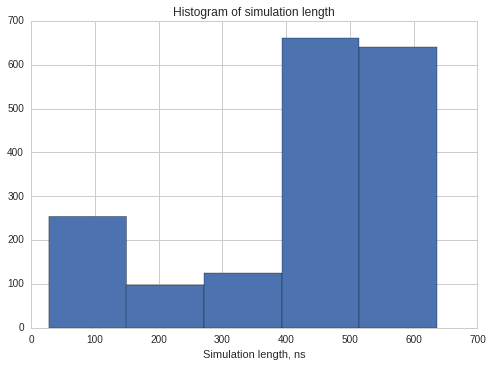

In [41]:
plt.clf()
plt.hist([t.shape[0] for t in protein_tica], bins=5)
plt.xlabel("Simulation length, ns")
plt.title("Histogram of simulation length")
hist_fig_file = "%s/simulation_length_histogram.png" %traj_dir
plt.savefig(hist_fig_file)

In [42]:
len(protein_tica)

1778

In [43]:
print(np.sum([protein_tica[i].shape[0] for i in bu72_ori_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in apo_ori_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in suf_ori_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in bu72_reseeded_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in apo_reseeded_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in suf_reseeded_trajs]))
print(np.sum([t.shape[0] for t in protein_tica]))


102705
115839
105298
145794
119620
166723
755979


In [44]:
protein_tica_bu72_conc = np.concatenate(protein_tica_bu72)
ligand_tica_bu72_conc =  np.concatenate(compat_verboseload(projected_features_dir))

In [45]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_bu72_conc, ligand_tica_bu72_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["bu72_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [47]:
n_clusters = 1000
clusterer_dir = "%s/bu72clusterer_%dclusters.h5" % (tica_dir, n_clusters)


In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

In [48]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)
bu72_msm = compat_verboseload(msm_model_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/bu72clusterer_1000clusters.h5"...


OSError: Unable to load /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/bu72clusterer_1000clusters.h5 using the pickle or joblib protocol.
Pickle: [Errno 2] No such file or directory: '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/bu72clusterer_1000clusters.h5'
Joblib: [Errno 2] No such file or directory: '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/bu72clusterer_1000clusters.h5'

In [49]:
'%s/bu72_clusterer1000.h5' %pp_tica_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer1000.h5'

In [50]:
pp_msm_lag_time=25
pp_n_clusters = 1000
prior_counts=1e-5
bu72_pp_resampled_traj_to_frames_file = "%s/bu72_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
bu72_pp_resampled_traj_to_frames = verboseload(bu72_pp_resampled_traj_to_frames_file)
bu72_pp_msm_file = "%s/bu72_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
bu72_pp_msm = verboseload(bu72_pp_msm_file)
bu72_pp_clusterer_file = '%s/bu72_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters)
bu72_pp_clusterer = verboseload('%s/bu72_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
bu72_pp_clusters_map = make_clusters_map(bu72_pp_clusterer)
bu72_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
bu72_pp_tic_components_dir = "%s" %pp_tica_dir
bu72_pp_tica_dir = bu72_pp_tic_components_dir
bu72_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl"
pp_tic_subsampled_features = '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl'
#pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
bu72_pp_tica = verboseload("%s/bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters))
bu72_pp_pnas_file = "%s/bu72_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
bu72_pp_pnas = verboseload(bu72_pp_pnas_file)
bu72_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
bu72_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer1000.h5"...
0
108
0
288
0
430
16
0
970
0
682
70
0
1109
0
0
0
64
573
0
735
318
334
0
505
1
214
607
65
0
110
6
0
0
43
90
675
125
681
632
267
154
0
0
0
0
0
0
672
271
0
162
0
1352
40
0
831
0
0
26
604
592
0
0
1257
7
0
539
0
0
49
316
0
1132
0
0
692
0
1
323
16
0
0
113
2
0
250
389
0
0
602
23
1780
25
65
81
0
1252
0
0
444
762
0
0
636
552

In [51]:
print("hi")

hi


In [52]:
pp_msm_lag_time=25
pp_n_clusters = 1000
prior_counts = 1e-5
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tica_file = "%s/apo_tica.h5" %pp_tica_dir
apo_pp_clusterer_file = '%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters)
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl"
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer1000.h5"...
0
154
0
0
0
0
559
2
0
0
58
129
818
414
0
777
0
1037
791
0
534
459
201
0
695
204
505
129
101
3
553
288
0
6
638
995
1
541
0
239
713
189
0
0
12
264
6
0
0
161
0
0
0
151
633
0
0
0
235
732
213
0
2
234
102
582
696
2
0
0
6
235
240
137
304
0
942
759
8
6
447
0
0
960
0
0
1255
3
0
1
1
336
0
986
23
434
0
1
154
0
1176
0
0
14
115
710

In [53]:
pp_analysis_dir = "%s-%sclusters_%dlag-time" %(analysis_dir, pp_n_clusters,pp_msm_lag_time)
analysis_dir = pp_analysis_dir
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

In [54]:
ref_receptors_dir = "/home/enf/md_simulations/MOR/bu72_ref_receptors" 
ref_features_dir = "%s/bu72_ref_receptors" %features_dir
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = new_features_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = new_feature_names, worker_pool=None, schemes=[], redo=True, binarize=None)

pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

epp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_feature_residues = compat_verboseload(bu72_pp_feature_residues_pkl)
lp_feature_residues = compat_verboseload(new_features_pkl)
print(len(lp_feature_residues))

ref_pp_features = pd.DataFrame(get_features(bu72_pp_ref_features_dir), columns=[str(f) for f in pp_feature_residues])
ref_lp_features = pd.DataFrame(get_features(ref_features_dir), columns=[str(f) for f in lp_feature_residues])
ref_pp_tica = pd.read_csv(bu72_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

#ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
#ref_lp_tica.columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_pp_tica, ref_lp_features*10., ref_pnas], axis=1)

dihedral_residues:
[]
There are 326 features to be used in featurization.
Saving contact feature residue pairs to disk.
About to featurize trajectories based on the chosen featurization scheme.
[Lig900-C1 to Asp147, Lig900-C1 to Ile144, Lig900-C1 to Lys233, Lig900-C1 to Met151, Lig900-C1 to Tyr148, Lig900-C1 to Val236, Lig900-C10 to Ala240, Lig900-C10 to Gly325, Lig900-C10 to His297, Lig900-C10 to Ile296, Lig900-C10 to Ile322, Lig900-C10 to Lys233, Lig900-C10 to Met151, Lig900-C10 to Trp293, Lig900-C10 to Trp318, Lig900-C10 to Tyr148, Lig900-C10 to Val236, Lig900-C10 to Val300, Lig900-C11 to Gly325, Lig900-C11 to His297, Lig900-C11 to Ile296, Lig900-C11 to Ile322, Lig900-C11 to Met151, Lig900-C11 to Trp293, Lig900-C11 to Trp318, Lig900-C11 to Tyr148, Lig900-C11 to Val236, Lig900-C11 to Val300, Lig900-C12 to Asp147, Lig900-C12 to Gly325, Lig900-C12 to Ile296, Lig900-C12 to Met151, Lig900-C12 to Tyr148, Lig900-C12 to Val236, Lig900-C13 to Asp147, Lig900-C13 to His297, Lig900-C13 to Ile14

In [55]:
tica_coords = compat_verboseload(projected_features_dir)
bu72_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"
apo_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"
bu72_pnas = compat_verboseload(bu72_pnas_file)
apo_pnas = compat_verboseload(apo_pnas_file)
bu72_tica_file = '%s/bu72_tica.h5' %pp_tica_dir
apo_tica_file = "%s/apo_tica.h5" %pp_tica_dir
bu72_tica = compat_verboseload(bu72_tica_file)
apo_tica = compat_verboseload(apo_tica_file)

bu72_aromatic = load_file(aromatic_features_file)

loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/bu72_aromatic_features/aromatic_features.dataset


In [56]:
pp_n_components = 10
bu72_pnas_dfs = []
for array in bu72_pnas:
    bu72_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
bu72_tica_dfs = []
for array in bu72_tica:
    bu72_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
lp_tica_dfs = []
for array in tica_coords:
    lp_tica_dfs.append(pd.DataFrame(array, columns=["bu72 tIC.%d" %i for i in range(1,n_components+1)]))
bu72_feature_dfs = []
bu72_features = load_file(new_features_file)
print("loaded bu72 features")
for array in bu72_features:
    bu72_feature_dfs.append(pd.DataFrame(array*10., columns=[str(f) for f in new_feature_names]))

bu72_pi_dfs = []
for array in bu72_aromatic:
    bu72_pi_dfs.append(pd.DataFrame(array, columns=aromatic_names))
new_bu72_feature_dfs = []
for i in range(0, len(bu72_pi_dfs)):
    new_bu72_feature_dfs.append(pd.concat([bu72_pi_dfs[i], bu72_feature_dfs[i]], axis=1))
bu72_feature_dfs = new_bu72_feature_dfs
    
apo_pnas_dfs = []
for array in apo_pnas:
    apo_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
apo_tica_dfs = []
for array in apo_tica:
    apo_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["apo tIC.%d" %i for i in range(1,n_components+1)]))



loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/reduced_features/reduced_features.dataset
loaded bu72 features


In [57]:
bu72_pnas = compat_verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


[ 13  17  18  30  41  49  53  73  76  93  95 104 107 113 115 126 153 176
 181 183 193 202 204 223 224 234 235 249 258 271 284 286 291 295 301 308
 309 312 314 329 346 347 357 368 373 375 401 402 411 414 418 423 439 444
 448 456 458 467 469 470 472 473 478 485 487 490 492 503 507 509 539 543
 544 550 578 580 592 594 598 599 612 618 624 631 636 640 646 647 661 671
 678 682 683 688 691 694 703 704 712 717 719 720 724 733 734 743 747 757
 758 760 761 769 778 786 794 804 805 807 810 832 834 836 837 846 850 855
 867 894 912 917 927 947 949 955 963 964 980 982 985 997]
[  3 144 396 589 967]


In [58]:
cluster_tica_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [59]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] > 0.8)].index.values
msm_intermediate_actives = bu72_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


[  7.54753041e-06   1.05590700e-05   3.96100349e-05   5.42814921e-05
   1.24236557e-04   2.26157298e-04   2.97986024e-04   3.20005471e-04
   3.75945882e-04   4.94213482e-04   1.08484971e-03   1.14698560e-03
   1.31126612e-02   1.37499390e-02   1.66453985e-02   2.53932195e-02
   3.14203622e-02   3.24606978e-02   4.11430266e-02   4.72906633e-02
   6.88470859e-02]
[  8 124 144 150 185 352 381 396 449 495 519 556 620 626 644 695 713 753
 763 781 930]
[495 695 713 150 519 753 781 763 644 352 449 381 124 626 620 396 556 144
 185   8 930]


In [60]:
#ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(pp_tic_subsampled_features)
protein_top_features_apo = [protein_top_features[i]*10. for i in apo_trajs]
protein_top_features_bu72 = [protein_top_features[i]*10. for i in bu72_trajs]



loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl


In [61]:
bu72_pp_feature_residues_pkl

'/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl'

In [62]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
bu72_pp_all_features, bu72_pp_tIC_features = interpret_tIC_components(bu72_pp_projection_operator_dir, bu72_pp_tic_components_dir, bu72_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(10, 5)
residue_importances_df.shape
(12, 2)
             feature_name      res_i      res_j  importance  \
7  Lys233_Ca To Lys303_Ca  Lys233_Ca  Lys303_Ca   -0.380112   
1  Ala304_Ca To Asn230_Ca  Ala304_Ca  Asn230_Ca    0.325877   
2  Ala304_Ca To Lys233_Ca  Ala304_Ca  Lys233_Ca    0.306402   
6  Ile308_Ca To Tyr299_Ca  Ile308_Ca  Tyr299_Ca    0.290794   
5  Ile308_Ca To Trp318_Ca  Ile308_Ca  Trp318_Ca   -0.284625   
3  Ala304_Ca To Tyr299_Ca  Ala304_Ca  Tyr299_Ca   -0.282444   
0        Leu339 To Val334     Leu339     Val334    0.251023   
9  Val236_Ca To Val300_Ca  Val236_Ca  Val300_Ca    0.222654   
4  Ile301_Ca To Val236_Ca  Ile301_Ca  Val236_Ca   -0.214483   
8  Lys303_Ca To Trp318_Ca  Lys303_Ca  Trp318_Ca    0.171570   

                  feature  
7  LYS233_CA to LYS303_CA  
1  ALA304_CA to ASN230_CA  
2  ALA304_CA to LYS233_CA  
6  ILE308_CA to TYR299_CA  
5  ILE308_CA to TRP318_CA  
3  ALA304_CA to TYR299_CA  
0        LEU339 t

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/interpret_tICs.py:97: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


             residue  importance
Asn230_Ca  Asn230_Ca    0.325877
Ala304_Ca  Ala304_Ca    0.323930
Lys233_Ca  Lys233_Ca    0.272077
Tyr299_Ca  Tyr299_Ca    0.262132
Ile308_Ca  Ile308_Ca    0.262023
Val334        Val334    0.251023
Leu339        Leu339    0.251023
Val300_Ca  Val300_Ca    0.222654
Ile301_Ca  Ile301_Ca   -0.214483
Val236_Ca  Val236_Ca    0.200797
Trp318_Ca  Trp318_Ca    0.148760
Lys303_Ca  Lys303_Ca    0.143986
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(8, 5)
residue_importances_df.shape
(16, 2)
             feature_name      res_i      res_j  importance  \
0         Leu88 To Phe338      Leu88     Phe338    0.434772   
2  Ala304_Ca To Asn230_Ca  Ala304_Ca  Asn230_Ca   -0.296001   
4  Leu339_Ca To Val334_Ca  Leu339_Ca  Val334_Ca    0.232692   
6   Phe338_Ca To Phe84_Ca  Phe338_Ca   Phe84_Ca    0.142109   
3  Asn328_Ca To Ile155_Ca  Asn328_Ca  Ile155_Ca    0.110870   
5  Phe289_Ca To Tyr336_Ca  Phe289_Ca  Tyr336_Ca    0.097682   
1  Ala111_Ca To 

In [63]:
all_traj_features = [pd.concat([bu72_feature_dfs[i], protein_top_features_bu72[i], bu72_tica_dfs[i], bu72_pnas_dfs[i]], axis=1) for i in range(0, len(bu72_tica_dfs))]

In [64]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [65]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
active_clusters = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["rmsd_npxxy_active"] < 0.35) & (cluster_features_averages["ALA240 to TRP293"] > 4) & (cluster_features_averages["ALA240 to TRP293"] < 7.) & (cluster_features_averages["TRP293 to TYR326"] < 6.) & (cluster_features_averages["TRP293 to TYR326"] > 5.) & (cluster_features_averages["ASP147 to TYR326"] < 4.)]
inactive_clusters = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.5) & (cluster_features_averages["rmsd_npxxy_inactive"] < 0.35) & (cluster_features_averages["PHE289 to TYR336"] > 8.)]
sources = [bu72_pp_msm.mapping_[i] for i in active_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
sinks = [bu72_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=100, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

[10, 18, 19, 27, 42, 49, 60, 62, 63, 65, 69, 79, 89, 90, 114, 127, 128, 132, 138, 148, 164, 174, 179, 183, 190, 193, 195, 206, 212, 216, 217, 225, 231, 232, 236, 274, 287, 290, 291, 293, 307, 317, 340, 350, 354, 356, 358, 370, 380, 386, 391, 395, 403, 405, 410, 414, 416, 424, 427, 429, 435, 437, 444, 445, 446, 447, 454, 456, 472, 475, 484, 486, 488, 495, 502, 506, 510, 512, 517, 521, 531, 540, 542, 546, 550, 556, 567, 573, 579, 586, 591, 594, 595, 596, 606, 614, 615, 619, 626, 635]
[4, 22, 24, 30, 33, 48, 52, 73, 76, 78, 88, 93, 102, 107, 116, 121, 159, 162, 194, 220, 233, 246, 249, 273, 280, 286, 345, 365, 376, 382, 384, 388, 396, 408, 449, 453, 471, 485, 497, 511, 536, 555, 570, 571, 605, 618, 624]
([array([206, 289, 598,  68,  22]), array([437,  77, 371, 558, 630, 577, 401, 555]), array([206, 496,  68,  22]), array([437, 289,  68, 275,  22]), array([206, 289, 315,  68,  22]), array([206,  77, 204,  68, 373,  22]), array([206, 598,  22]), array([206, 204, 558, 237,  22]), array([206,

In [66]:
inv_tpt_paths

[[329, 467, 920, 114, 36],
 [694, 126, 601, 859, 973, 887, 643, 854],
 [329, 770, 114, 36],
 [694, 467, 114, 440, 36],
 [329, 467, 507, 114, 36],
 [329, 126, 324, 114, 603, 36],
 [329, 920, 36],
 [329, 324, 859, 379, 36],
 [329, 985, 601, 920, 398, 36],
 [104, 467, 651, 114, 251],
 [329, 720, 952, 792],
 [329, 877, 868, 36],
 [329, 868, 36],
 [329, 601, 251],
 [329, 27, 251],
 [73, 467, 324, 868, 36],
 [786, 525, 419, 225, 133, 239, 603, 36],
 [329, 507, 603, 36],
 [694, 848, 398, 36],
 [329, 234, 877, 732, 440, 36],
 [329, 402, 601, 398, 379, 36],
 [636, 838, 10, 149, 331, 167, 56],
 [73, 770, 868, 36],
 [329, 651, 251],
 [836, 402, 467, 601, 114, 603, 36],
 [329, 848, 398, 379, 36],
 [73, 734, 234, 803, 36],
 [694, 920, 603, 36],
 [73, 487, 985, 920, 603, 36],
 [836, 126, 27, 603, 36],
 [836, 487, 467, 770, 36],
 [636, 414, 838, 459, 149, 480, 167, 56],
 [717, 53, 293, 64, 358, 398, 603, 36],
 [104, 402, 985, 324, 770, 868, 36],
 [73, 994, 36],
 [73, 402, 985, 859, 973, 427, 617],
 [

In [ ]:
for i in range(0,100):
    print(cluster_features_averages.iloc[inv_tpt_paths[i][-1]]["TRP293 to TYR326"])

In [ ]:
plt.hist(features_eq["LYS233_CA to LYS303_CA"], bins=50)

In [ ]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [bu72_pp_msm.mapping_[i] for i in tm6_out_clusters if i in bu72_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

In [62]:
inactive_clusters = cluster_features_averages.loc[cluster_features_averages["ASN150 to PHE289"] < 7.5]
active_clusters = cluster_pnas_averages.loc[(cluster_features_averages["ASP147 to TYR326"] < 4.) & (cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]




In [63]:
from imp import reload
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

def find_good_msm(msm_object, clusters_map, start_clusters, target_clusters, n_steps, save_file=None):
    redo = True
    while redo:
        msm_traj_index_pairs, cluster_list = generate_msm_traj_index_series(msm_object, random.choice(start_clusters), n_steps, clusters_map, None)
        n_appearances = 0
        for cluster in target_clusters:
            n_appearances += len([c for c in cluster_list if c==cluster])
        if float(n_appearances) / float(n_steps) > 0.05:
            redo = False
        else:
            print(float(n_appearances) / float(n_steps))
    return msm_traj_index_pairs

saved_msm_traj_index_pairs_file = "%s/msm_traj_index_pairs2.h5" %analysis_dir
#if 1==1:
if not os.path.exists(saved_msm_traj_index_pairs_file):
    msm_traj_index_pairs = find_good_msm(bu72_pp_msm, bu72_pp_clusters_map, active_clusters.index.values.tolist(), inactive_clusters.index.values.tolist(), 10000)
    with open(saved_msm_traj_index_pairs_file, "wb") as f:
        pickle.dump(msm_traj_index_pairs, f, protocol=2)
else:
    with open(saved_msm_traj_index_pairs_file, "rb") as f:
        msm_traj_index_pairs = pickle.load(f)

protein_ligand_msm_featurized = resample_features_by_msm_trajectory(all_traj_features, msm_traj_index_pairs)

saved_msm_traj_index_pairs_file = "%s/msm_traj_index_pairs2.h5" %analysis_dir
with open(saved_msm_traj_index_pairs_file, "wb") as f:
    pickle.dump(msm_traj_index_pairs, f, protocol=2)

we are operating on biox3


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:496: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=True,window=25).mean()
  pd.rolling_mean(df, smoothing, center=True, min_periods=None)[var].plot(ax=axes[i], linewidth=2.5, title=var, c=c)


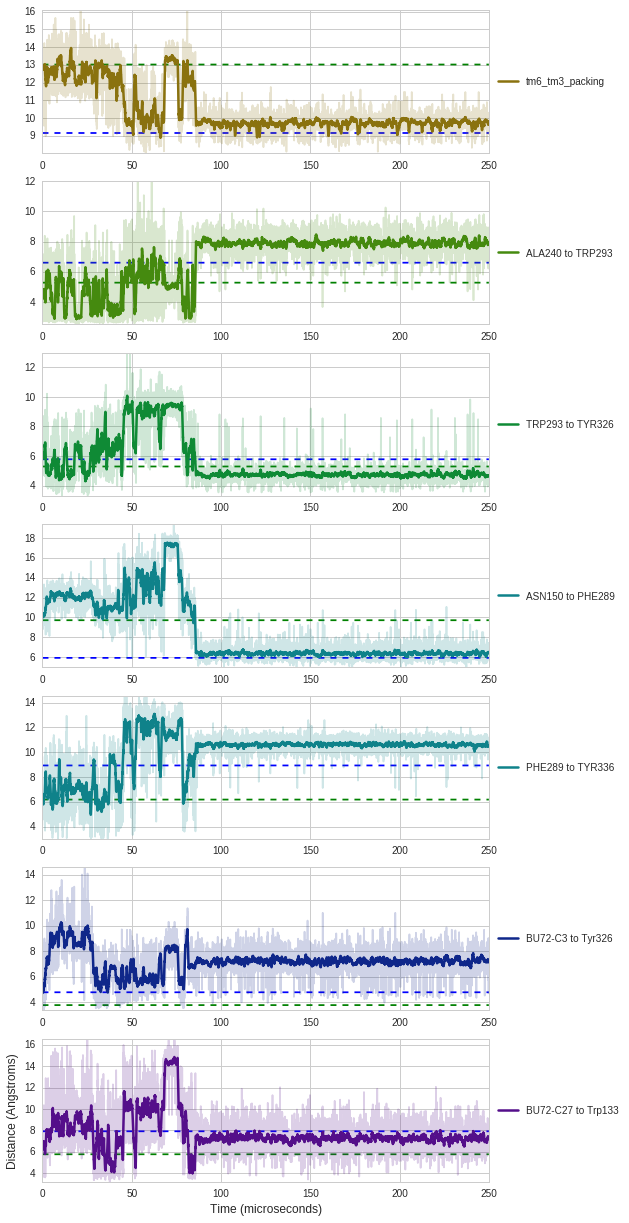

In [64]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=25
names = plmf.columns.values.tolist()
for i, name in enumerate(names):
    if "LIG" in str(name):
        names[i] = "BU72" + name[3:]
    if "Lig900" in str(name):
        names[i] = "BU72" + name[6:]
plmf.columns = names
plmf.index = (plmf.index.values * pp_msm_lag_time) / 1000

names = ref_features.columns.values.tolist()
for i, name in enumerate(names):
    if "LIG" in str(name):
        names[i] = "BU72" + name[3:]
    if "Lig900" in str(name):
        names[i] = "BU72" + name[6:]
new_ref_df = copy.deepcopy(ref_features)
new_ref_df.columns=names


pp_lp_features = ["tm6_tm3_packing", "ALA240 to TRP293", "TRP293 to TYR326", "ASN150 to PHE289", "PHE289 to TYR336", "BU72-C3 to Tyr326", "BU72-C27 to Trp133"]
#pp_lp_features = ["tm6_tm3_packing", "ASP147 to TYR326", "TRP293 to TYR326", "ALA240 to TRP293", "ASN150 to PHE289", "PHE289 to PRO244", "PHE289 to TYR336", "ASP114 to TYR336", "LYS233_CA to LYS303_CA"]#, "TYR128 to TYR326", "SER119_CA to TYR326_CA", "BU72-C4 to Tyr326", "BU72-C23 to Gln124", "BU72-C7 to Trp293", "BU72-C27 to Trp133"]
#plot_features = plmf[["tm6_tm3_packing", "PHE338 to PHE84", "PHE289 to ASN150", "TRP293 to ALA240", "HIS319_CA to TYR75_CA", "TYR336 to ASP114",  "BU72-N1 to Tyr326", "BU72-C25 to Trp133", "BU72-C23 to Gln124", "BU72-C26 to Leu219"]]
plot_features = plmf[pp_lp_features]

plot_df_rolling(plot_features.iloc[::1], "%s/key_measurements_with_bu72.png" %(analysis_dir), True, smoothing=smoothing, include_original=True, subplots=True, min_periods=None, ref_df=new_ref_df, color="RdBu_r")
plt.show()

In [65]:
[n for n in ref_features.columns.values.tolist() if "LIG" in n.upper()]

['Lig900-C1 to Asp147',
 'Lig900-C1 to Ile144',
 'Lig900-C1 to Lys233',
 'Lig900-C1 to Met151',
 'Lig900-C1 to Tyr148',
 'Lig900-C1 to Val236',
 'Lig900-C10 to Ala240',
 'Lig900-C10 to Gly325',
 'Lig900-C10 to His297',
 'Lig900-C10 to Ile296',
 'Lig900-C10 to Ile322',
 'Lig900-C10 to Lys233',
 'Lig900-C10 to Met151',
 'Lig900-C10 to Trp293',
 'Lig900-C10 to Trp318',
 'Lig900-C10 to Tyr148',
 'Lig900-C10 to Val236',
 'Lig900-C10 to Val300',
 'Lig900-C11 to Gly325',
 'Lig900-C11 to His297',
 'Lig900-C11 to Ile296',
 'Lig900-C11 to Ile322',
 'Lig900-C11 to Met151',
 'Lig900-C11 to Trp293',
 'Lig900-C11 to Trp318',
 'Lig900-C11 to Tyr148',
 'Lig900-C11 to Val236',
 'Lig900-C11 to Val300',
 'Lig900-C12 to Asp147',
 'Lig900-C12 to Gly325',
 'Lig900-C12 to Ile296',
 'Lig900-C12 to Met151',
 'Lig900-C12 to Tyr148',
 'Lig900-C12 to Val236',
 'Lig900-C13 to Asp147',
 'Lig900-C13 to His297',
 'Lig900-C13 to Ile144',
 'Lig900-C13 to Ile296',
 'Lig900-C13 to Trp318',
 'Lig900-C13 to Tyr148',
 'Lig9

In [66]:
"%s/key_measurements_with_bu72.png" %(analysis_dir)

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time/key_measurements_with_bu72.png'

In [67]:
all_features_conc = pd.concat(all_traj_features, axis=0)

In [ ]:
data = all_features_conc.loc[(all_features_conc[ 'TRP293-CD2 to PHE289-CG: Pi T'] == 1.) | (all_features_conc['TRP293-CG to PHE289-CG: Pi T'] == 1.)]["PHE289 to ASN150"].values
print(data.shape)
plt.hist(data, bins=100)
plt.show()

In [ ]:
plt.hist(all_features_conc.loc[(all_features_conc[ 'TRP293-CD2 to PHE289-CG: Pi T'] == 0.) & (all_features_conc['TRP293-CG to PHE289-CG: Pi T'] == 0.)]["PHE289 to ASN150"].values, bins=100)
plt.show()

In [68]:
projected_features = compat_verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, bu72_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = compat_verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_bu72_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

bu72_pp_resampled_traj_index_pairs = []
for traj in bu72_pp_resampled_traj_to_frames.keys():
    [bu72_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in bu72_pp_resampled_traj_to_frames[traj]]

apo_pp_resampled_traj_index_pairs = []
for traj in apo_pp_resampled_traj_to_frames.keys():
    [apo_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in apo_pp_resampled_traj_to_frames[traj]]

def create_features_eq_df(resampled_traj_index_pairs, feature_dfs, protein_top_features, ligand_top_features, pp_tica_resampled, ligand_tica_resampled, pp_pnas):
    all_dfs = []
    pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, resampled_traj_index_pairs)
    all_dfs.append(pp_features_eq)
    if ligand_top_features is not None:
        ligand_features_eq = resample_features_by_msm_trajectory(ligand_top_features, resampled_traj_index_pairs)
        all_dfs.append(ligand_features_eq)
    pp_tica_eq = pd.DataFrame(pp_tica_resampled, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
    all_dfs.append(pp_tica_eq)
    if ligand_tica_resampled is not None:
        ligand_tica_eq = pd.DataFrame(ligand_tica_resampled, columns=["bu72 tIC.%d" %i for i in range(1,n_components+1)])
        all_dfs.append(ligand_tica_eq)
    pnas_eq = pd.DataFrame(pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
    all_dfs.append(pnas_eq)
    features_eq = pd.concat(all_dfs, axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]
    return features_eq

features_eq = create_features_eq_df(bu72_pp_resampled_traj_index_pairs, bu72_feature_dfs, protein_top_features_bu72, bu72_feature_dfs, bu72_pp_tica, tica_resampled, bu72_pp_pnas)
apo_features_eq = create_features_eq_df(apo_pp_resampled_traj_index_pairs, None, protein_top_features_apo, None, apo_pp_tica, None, apo_pp_pnas)

features_eq_file = "%s/bu72_features_eq.pkl" %analysis_dir
with open(features_eq_file, "wb") as f:
    pickle.dump(features_eq, f, protocol=2)
print(features_eq_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/tica_msm_lag-time30_clusters1000_resampled.h5"... (<class 'numpy.ndarray'>)
/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time/bu72_features_eq.pkl


In [69]:
features_eq.columns

Index(['LEU158_CA to VAL285_CA', 'CYS79 to PRO122', 'ASN230_CA to CYS235_CA',
       'ASN150_CA to SER145_CA', 'ILE256_CA to LEU275_CA',
       'ALA304_CA to TYR299_CA', 'MET281_CA to THR103_CA', 'CYS79 to TYR326',
       'ARG280 to VAL285', 'HIS319_CA to THR67_CA',
       ...
       'rmsd_DRY_active', 'rmsd_DRY_inactive', 'rmsd_npxxy_active',
       'rmsd_npxxy_inactive', 'rmsd_triad_active', 'rmsd_triad_inactive',
       'tm6_tm3_dist', 'tm6_tm3_packing', 'tm6_tm5_packing',
       'tm6_tm7_packing'],
      dtype='object', length=552)

In [70]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [152]:
def custom_lim_finder(values, n_stds=1.):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - n_stds*stds[i], maxs[i] + n_stds*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [72]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


(array([   3.,    2.,   12.,   14.,   52.,   65.,   87.,  134.,  105.,
         121.,  170.,  164.,  200.,  208.,  216.,  240.,  244.,  218.,
         230.,  235.,  225.,  261.,  258.,  265.,  294.,  311.,  318.,
         304.,  274.,  290.,  216.,  210.,  130.,  147.,  149.,  121.,
         121.,  156.,  131.,  213.,  274.,  289.,  322.,  405.,  469.,
         482.,  639.,  701.,  766.,  770.,  766.,  820.,  860.,  800.,
         774.,  643.,  582.,  454.,  405.,  281.,  203.,  154.,  143.,
          83.,   54.,   53.,   30.,   44.,   30.,   23.,   32.,   29.,
          31.,   32.,   46.,   41.,   35.,   36.,   55.,   29.,   50.,
          26.,   23.,   20.,   14.,   11.,   15.,   10.,    9.,    5.,
           3.,    5.,    2.,    1.,    2.,    0.,    2.,    0.,    0.,    1.]),
 array([  5.13553083,   5.25122121,   5.36691159,   5.48260197,
          5.59829235,   5.71398273,   5.82967311,   5.94536349,
          6.06105387,   6.17674425,   6.29243463,   6.40812501,
          6.523815

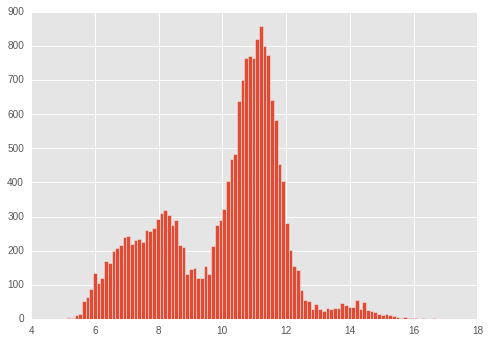

In [73]:
plt.hist(apo_features_eq["CYS159 to TYR336"], bins=100)

In [285]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

#intermediates = cluster_features_averages.loc[(cluster_features_averages["rmsd_npxxy_active"] < 0.3)].index.values# & (cluster_features_averages["Lig1-C9 to Trp318"] < 6.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["PHE338 to PHE84"] < 8.) & (cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_active"] < 5.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["PHE338 to PHE84"] > 10.) & (cluster_features_averages["rmsd_npxxy_active"] < 0.4)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["Lig900-C10 to Met151"] < 4.5) & (cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.5) & (cluster_features_averages["rmsd_npxxy_inactive"] < 0.35) & (cluster_features_averages["ALA240 to TRP293"] > 5.)].index.values# & (cluster_features_averages["ASN150 to PHE289"] > 14.)].index.values# & (cluster_features_averages["ASP147 to TYR326"] > 4.) & (cluster_features_averages["tm6_tm3_packing"] < 11.)].index.values #& (cluster_features_averages["ASN150 to PHE289"] < 8.)].index.values# & (cluster_features_averages["rmsd_npxxy_inactive"] < 0.35) & (cluster_features_averages["tm6_tm3_packing"] < 10.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["Lig900-C17 to Tyr326"] < 4.5) & (cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
intermediates = cluster_features_averages.loc[(cluster_features_averages["Lig900-C17 to Tyr326"] < 4.5) & (cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values# & (cluster_features_averages["rmsd_npxxy_inactive"] < 0.35) & (cluster_features_averages["TRP293 to TYR326"] > 5.)].index.values


intermediates = intermediates.tolist()
print(intermediates)
counts = [len(bu72_pp_clusters_map[i]) for i in range(0, pp_n_clusters)]
for c in np.argsort(-1.0*np.array(counts)):
    if c in intermediates:
        print(c)
#print(intermediates)
#find_most_populated_intermediates(bu72_pp_msm, intermediates)

we are operating on biox3
[22, 24, 25, 28, 39, 64, 70, 80, 97, 105, 111, 116, 122, 133, 137, 149, 151, 159, 160, 175, 193, 197, 213, 218, 222, 225, 230, 233, 245, 246, 252, 275, 288, 290, 293, 294, 299, 300, 304, 306, 341, 344, 353, 354, 358, 359, 361, 382, 383, 386, 387, 389, 394, 400, 403, 408, 409, 412, 419, 455, 489, 493, 504, 530, 531, 537, 543, 544, 562, 569, 588, 593, 598, 609, 616, 621, 630, 634, 635, 638, 642, 657, 667, 673, 679, 689, 701, 711, 726, 737, 739, 745, 749, 757, 767, 775, 785, 787, 814, 820, 824, 826, 832, 849, 857, 859, 863, 864, 880, 896, 898, 907, 910, 911, 918, 925, 939, 947, 951, 963, 972, 973, 975, 984, 992, 997]
382
419
290
609
64
97
832
299
225
657
383
175
543
562
489
293
133
493
898
785
306
353
537
116
739
137
910
992
409
359
39
288
149
634
745
222
105
122
24
820
972
294
767
911
531
896
642
389
975
711
880
403
252
621
344
630
341
701
667
593
918
246
635
400
358
22
394
386
160
673
907
973
275
737
530
408
588
387
859
939
151
544
757
638
951
864
749
218
28
35

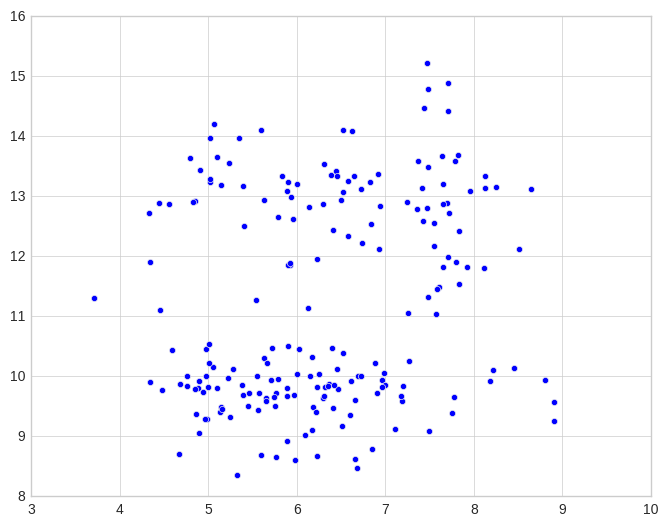

In [199]:
plt.scatter(features_eq["Lig900-C17 to Trp318"].iloc[::100], features_eq["tm6_tm3_packing"].iloc[::100])

In [203]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
intermediates = cluster_features_averages.loc[(cluster_features_averages["TYR336 to PHE289"] > 12.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["PHE289 to ASN150"] > 16.) & (cluster_features_averages["TYR336 to PHE289"] > 12.)].index.values# & (cluster_features_averages["Lig1-C9 to Trp318"] < 6.)].index.values
print(intermediates)
find_most_populated_intermediates(bu72_pp_msm, intermediates)

we are operating on biox3


KeyError: 'TYR336 to PHE289'

In [ ]:

all_traj_features_np = [f.values for f in all_traj_features_apo]

cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["PHE338 to PHE84"] < 10.)].index.values
print(intermediate_actives)
msm_intermediate_actives = np.concatenate(apo_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(apo_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(apo_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

#tpt_paths_features = []
#for tpt_path in inv_tpt_paths:
#    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

In [ ]:
prot_features = list(set([str(g) for l in bu72_pp_tIC_features for g in l]))
f1 = pd.concat([f*10. for f in protein_top_features_apo], axis=0)
f2 = pd.concat([f for f in apo_tica_dfs])
f3 = pd.concat([f for f in apo_pnas_dfs])
prot_lig_features = pd.concat([f1,f2,f3],axis=1)
all_traj_features_apo = [pd.concat([protein_top_features_apo[i], apo_tica_dfs[i], apo_pnas_dfs[i]], axis=1) for i in range(0, len(apo_tica_dfs))]



all_traj_features_np = [f.values for f in all_traj_features_apo]
cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["PHE338 to PHE84"] < 8.) & (cluster_features_averages["tm6_tm3_packing"] < 10.)].index.values
msm_intermediate_actives = apo_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

In [247]:
import custom_msm
reload(custom_msm)
from custom_msm import *

graph_file = "%s/bu72_clusters_%d_msm_lag_time%d_graph_3.graphml" % (tica_dir, n_clusters, pp_msm_lag_time)
bu72_cluster_attributes = {}
for i, title in enumerate(["mOR tIC.%d" %i for i in range(1,n_components+1)]):
    bu72_cluster_attributes[title] = cluster_features_averages[title].values
attributes = ["tm6_tm3_packing", "rmsd_npxxy_inactive", "Lig900-N1 to Tyr326", "Lig900-C24 to Gln124", "Lig900-C21 to Gln124", "Lig900-C27 to Trp133", "Lig900-C17 to Tyr326", "Lig900-C7 to Trp293", "Lig900-C7 to His297", "Lig900-C16 to Trp318", "HIS319_CA to TYR75_CA", "tm6_tm3_packing", "ASN150 to PHE289", "PHE289 to TYR336", "LEU88 to PHE338", "ASP114 to TYR336", "LYS303_CA to TRP318_CA", "TRP293 to TYR326", "ALA240 to TRP293", "PHE289 to PRO244", "ASP147 to TYR326"]
for attribute in attributes:
    bu72_cluster_attributes[attribute] = cluster_features_averages[attribute].values
msm_attributes = {'eq_pops': bu72_pp_msm.populations_}
graph = construct_graph(bu72_pp_msm_file, bu72_pp_clusterer_file, pp_n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None, msm_attributes=msm_attributes, cluster_attributes=bu72_cluster_attributes, min_prob=1e-3)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
Number of nodes in graph:
646


In [248]:
graph_file

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/bu72_clusters_1000_msm_lag_time25_graph_3.graphml'

In [242]:
pp_feature_names = protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]
lp_feature_names = [str(f) for f in new_feature_names]

#all_pp_features_onehot, pp_names_onehot = multi_onehot_trajectories([t[pp_feature_names].values for t in all_traj_features], pp_feature_names, subsample=100, binary_keep_one=True)
#all_lp_features_onehot, lp_names_onehot = multi_onehot_trajectories([t[lp_feature_names].values for t in all_traj_features], lp_feature_names, custom_bounds=[5.0], subsample=100, binary_keep_one=True)

#all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot = multi_onehot_trajectories([features_eq[pp_feature_names].values], pp_feature_names, subsample=1, binary_keep_one=True)
#all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot = multi_onehot_trajectories([features_eq[lp_feature_names].values], lp_feature_names, custom_bounds=[5.0], subsample=1, binary_keep_one=True)

In [113]:
if os.path.exists("%s/onehot_features.h5" %(analysis_dir)):
    all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot, all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot = verboseload("%s/onehot_features.h5" %(analysis_dir))
else:
    verbosedump((all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot, all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot), "%s/onehot_features.h5" %(analysis_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time/onehot_features.h5"...


In [122]:
print(len(lp_names_onehot))
print(len(pp_names_onehot))

326
565


In [115]:
save_name = "features_eq_multionehot_pp_vs_lp_logistic_scores"
#if 1==1:
if not os.path.exists("%s/%s.h5" %(analysis_dir, save_name)):
    data_i = pd.concat(all_lp_features_onehot, axis=0).values[::100]
    data_j = pd.concat(all_pp_features_onehot, axis=0).values[::100]
    pp_lp_scores, pp_lp_importances = compute_sl_matrix(data_i, data_j, n_trees=500, n_folds=5, max_depth=3, task="classification", model_type="logistic", worker_pool=dview, parallel=False)
    verbosedump(pp_lp_scores, "%s/%s_scores.h5" %(analysis_dir, save_name))
    verbosedump(pp_lp_importances, "%s/%s_importances.h5" %(analysis_dir, save_name))
else:
    all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot, all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot = verboseload("%s/onehot_features.h5" %(analysis_dir))
    pp_lp_scores = compat_verboseload("%s/%s_scores.h5" %(analysis_dir, save_name))
    pp_lp_importances = compat_verboseload("%s/%s_importances.h5" %(analysis_dir, save_name))




loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time/onehot_features.h5"...


In [116]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

save_name = "features_eq_multionehot_pp_vs_pp_logistic_scores"
#if 1==1:
if not os.path.exists("%s/%s.h5" %(analysis_dir, save_name)):
    data_i = pd.concat(all_pp_features_onehot, axis=0).values[::100]
    data_j = pd.concat(all_pp_features_onehot, axis=0).values[::100]
    pp_pp_scores, pp_pp_importances = compute_sl_matrix(data_i, data_j, n_trees=500, n_folds=5, max_depth=3, task="classification", model_type="logistic", worker_pool=dview, parallel=False, symmetric=True)
    verbosedump(pp_pp_scores, "%s/%s_scores.h5" %(analysis_dir, save_name))
    verbosedump(pp_pp_importances, "%s/%s_importances.h5" %(analysis_dir, save_name))
else:
    pp_pp_scores = compat_verboseload("%s/%s_scores.h5" %(analysis_dir, save_name))
    pp_pp_importances = compat_verboseload("%s/%s_importances.h5" %(analysis_dir, save_name))



/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


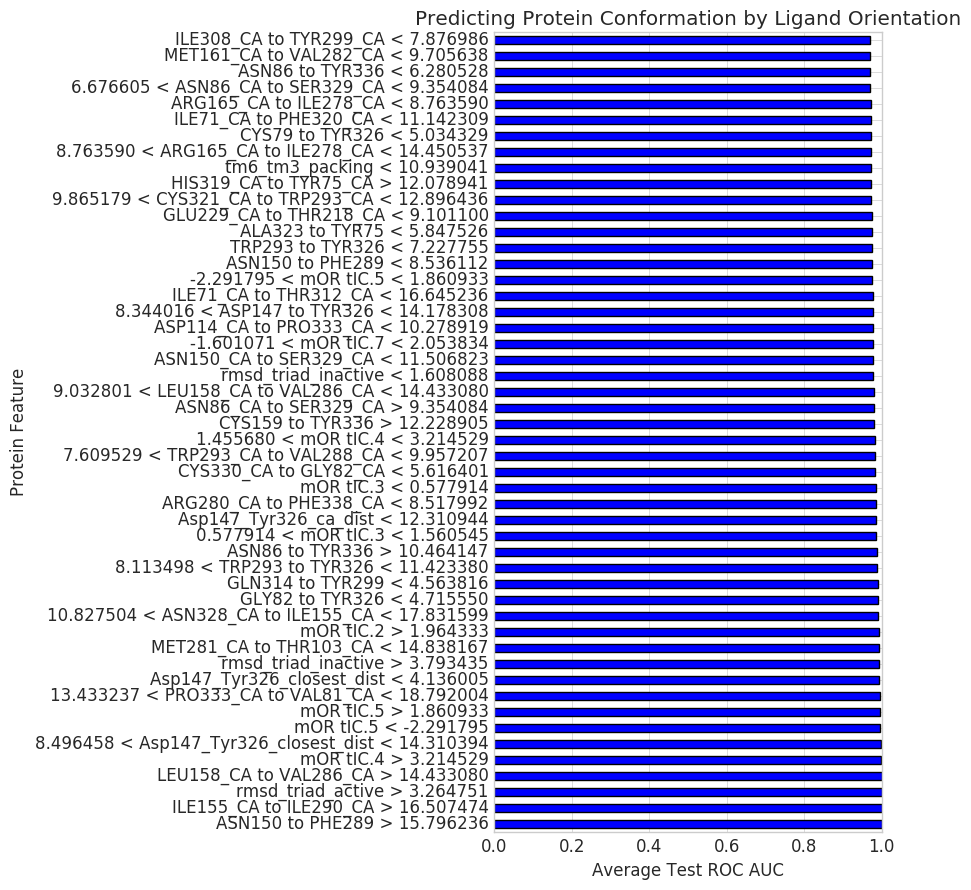

In [117]:
reload(matplotlib)
import seaborn as sns
sns.set_style("whitegrid")
auc_scores_df = pd.Series(pp_lp_scores, index=pp_names_onehot).sort(ascending=False, inplace=False)
auc_scores_df = auc_scores_df.iloc[:50]
title = "Predicting Protein Conformation by Ligand Orientation"
auc_scores_df.plot(kind='barh', title=title, figsize=(5,10))
plt.xlabel("Average Test ROC AUC")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_oneshot_%s.pdf" %(analysis_dir, title))
plt.show()

we are operating on biox3
['tm6_tm3_packing < 10.939041']
tm6_tm3_packing < 10.939041
tm6_tm3_packing
Lig900-C3 to Trp293 < 5.000000     2.625409
Lig900-C4 to Trp293 < 5.000000     1.927968
Lig900-C21 to Tyr326 < 5.000000    1.854021
Lig900-C5 to Met151 < 5.000000     1.536973
Lig900-C27 to Ile144 < 5.000000    1.442056
Lig900-N2 to Asp147 < 5.000000     1.391807
Lig900-C9 to Lys233 < 5.000000     1.307534
Lig900-C17 to Trp318 < 5.000000    1.287623
Lig900-N1 to Trp293 < 5.000000     1.286791
Lig900-C8 to His297 < 5.000000     1.253819
Lig900-C25 to Trp133 < 5.000000    1.205524
Lig900-C26 to Val143 < 5.000000    1.160900
Lig900-C13 to Ile296 < 5.000000    1.137697
Lig900-C16 to Cys321 < 5.000000    1.124473
Lig900-C20 to Thr120 < 5.000000    1.118988
Lig900-C8 to Val300 < 5.000000     1.029752
Lig900-C7 to His297 < 5.000000     1.022638
Lig900-C1 to Tyr148 < 5.000000     1.021247
Lig900-C18 to Gly325 < 5.000000    0.932850
Lig900-O1 to Trp293 < 5.000000     0.931752
Lig900-O2 to Cys32

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:825: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  df.index.values.tolist() if "<" in n]].iloc[:n_lp_features]


(200,)
(200,)
(200,)
Lig900-C4 to Trp293 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C21 to Tyr326 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C5 to Met151 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C27 to Ile144 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-N2 to Asp147 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C9 to Lys233 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C17 to Trp318 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-N1 to Trp293 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C8 to His297 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C25 to Trp133 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C26 to Val143 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C13 to Ile296 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C16 to Cys321 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C20 to Thr120 < 5.000000
tm6_tm3_packing
(200,)
(200,)
(200,)
Lig900-C8 to Val300

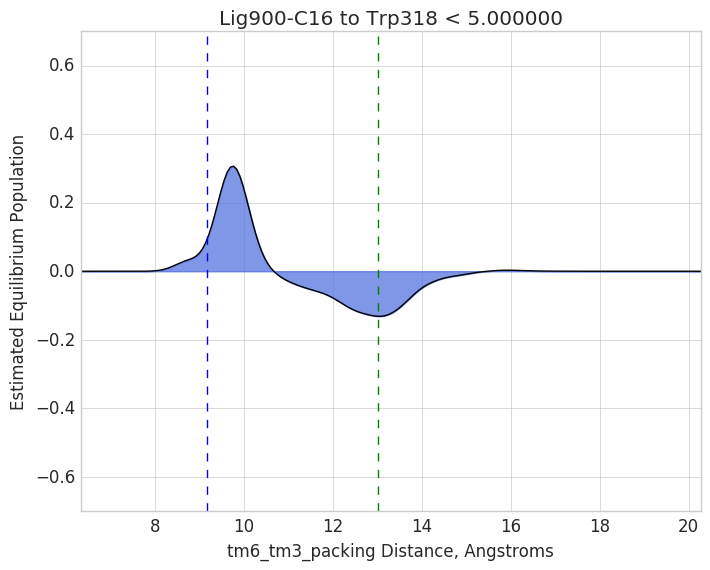

In [125]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

pp_pp_importances_df = pd.DataFrame(pp_pp_importances, columns=pp_names_onehot, index=pp_names_onehot)
pp_lp_importances_df = pd.DataFrame(pp_lp_importances, columns=pp_names_onehot, index=lp_names_onehot)


protein_features = ["tm6_tm3_packing"]#, "TRP293 to TYR326", "PHE289 TO TYR336", "TYR75 to HIS319", "ASP114 to TYR336"]
plot_lp_pp_model_outcomes(pp_lp_importances_df, pp_lp_scores, analysis_dir, features_eq, pd.concat(all_lp_features_onehot,axis=0), n_pp_features=0,
                                  n_lp_features=200, protein_features=protein_features, ref_features_df=ref_features, redo=True)

In [ ]:
analysis_d

we are operating on biox3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
plotted


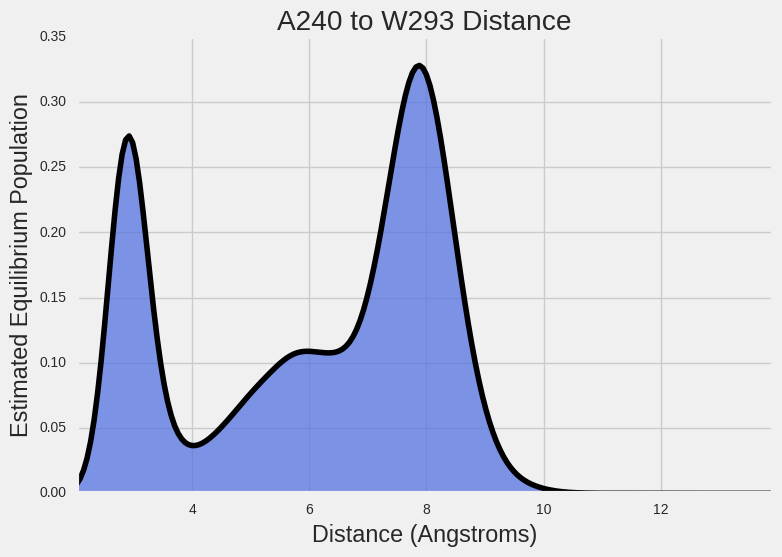

In [311]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
%load_ext autoreload
%autoreload 2
with plt.style.context(('classic')):
    compute_and_plot_single_kde(features_eq["ALA240 to TRP293"].values, "A240 to W293 Distance", "Distance (Angstroms)", None, custom_bounds=None, custom_y_bounds=None)


In [161]:
plt.show()

(200,)
(200,)
(200,)


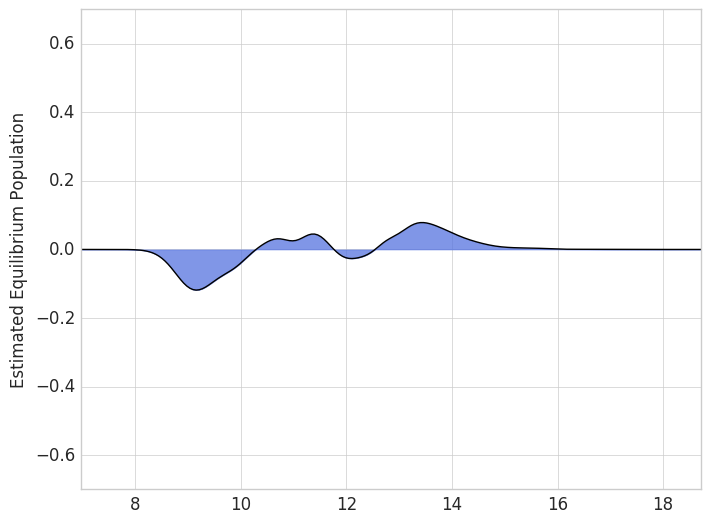

In [185]:
df = features_eq
df2 = pd.concat(all_lp_features_onehot,axis=0)
name = "ALA240 to TRP293"
compute_and_plot_kde_difference(df.loc[df[name] < 4.]["tm6_tm3_packing"].values[::1], df.loc[df[name] > 4.]["tm6_tm3_packing"].values[::1], "", 
                                      "", 
                                      None,
                                      custom_bounds=None, custom_y_bounds=[-0.7,0.7],
                                      crystal_values=None)

In [153]:
all_lp_features_onehot[0].shape

(19984, 326)

In [930]:


pp_pp_importances_df = pd.DataFrame(pp_pp_importances, columns=pp_names_onehot, index=pp_names_onehot)
pp_lp_importances_df = pd.DataFrame(pp_lp_importances, columns=pp_names_onehot, index=lp_names_onehot)

pp_lp_edge_df = make_edge_list(pp_lp_scores, pp_lp_importances_df, ).sort("importance", inplace=False, ascending=False)
pp_pp_edge_df = make_edge_list(pp_pp_scores, pp_pp_importances_df).sort("importance", inplace=False, ascending=False)
edge_df = pd.concat([pp_lp_edge_df, pp_pp_edge_df], axis=0)


we are operating on biox3
0.939393939394
0
0.651428571429
0.45641025641
0.916666666667
3
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.904
11
0.848
12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.971212121212
20
0.95078125
21
0.935466666667
22
0.913810741688
23
0.0
0.9375
25
0.912533333333
26
0.9808
27
0.84921875
28
0.93452685422
29
0.85811965812
30
0.978
31
0.992
32
0.0
0.0
0.965367965368
35
0.934523809524
36
0.988571428571
37
0.928
38
0.893866666667
39
0.912
40
0.0
0.822222222222
42
0.911333333333
43
0.742105263158
0.99921875
45
0.0
0.957333333333
47
0.0
0.851282051282
49
0.887179487179
50
0.0
0.0
0.0
0.0
0.791666666667
0.730555555556
0.0
0.0
0.0
0.0
0.860526315789
61
0.725714285714
0.707894736842
0.793142857143
0.761904761905
0.781818181818
0.0
0.0
0.6605
0.991478696742
70
0.998496240602
71
1.0
72
0.954887218045
73
0.871212121212
74
0.987428571429
75
0.953142857143
76
0.0
0.0
0.969230769231
79
0.0
0.0
0.964102564103
82
0.0
0.0
0.812571428571
85
0.821714285714
86
0.0
0.946703296703
88
0.845833333333
89
0.912121212

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


0.997619047619
36
0.997714285714
37
0.974857142857
38
0.981333333333
39
0.994133333333
40
0.0
0.840909090909
42
0.992
43
0.889473684211
44
0.99765625
45
0.0
0.950666666667
47
0.0
0.733333333333
0.85641025641
50
0.0
0.0
0.0
0.0
0.998611111111
55
0.993055555556
56
0.0
0.0
0.0
0.0
0.992105263158
61
0.974857142857
62
0.963157894737
63
0.994285714286
64
0.924404761905
65
0.992207792208
66
0.0
0.0
0.7655
1.0
70
0.999498746867
71
1.0
72
0.992481203008
73
0.94797979798
74
0.985142857143
75
0.981714285714
76
0.0
0.0
0.958974358974
79
0.0
0.0
0.748717948718
0.0
0.0
0.995428571429
85
0.984
86
0.0
0.987912087912
88
0.970833333333
89
1.0
90
1.0
91
0.958558558559
92
0.982683982684
93
0.990990990991
94
0.9635
95
0.997368421053
96
0.990625
97
0.996536796537
98
0.85
99
0.0
0.0
0.0
0.789743589744
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.99921875
115
0.996875
116
0.975520833333
117
0.999498746867
118
0.964705882353
119
0.74358974359
0.995428571429
121
0.0
0.997866666667
123
0.992307692308
124
0.0
0.

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [186]:
edge_df.loc[(edge_df.feature_i.str.contains('Lig')) & (edge_df.feature_j.str.contains('tm6_tm3_packing'))]

NameError: name 'edge_df' is not defined

In [847]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

graph_file = "%s/logistic_graph_cutoff1pt0.graphml" %analysis_dir

new_edge_df = copy.deepcopy(edge_df)
new_edge_df.feature_i =edge_df.feature_j
new_edge_df.feature_j = edge_df.feature_i
logistic_graph, logistic_graph_transpose = build_causality_network(new_edge_df, graph_file, importance_cutoff=1e-4, lig_name="lig", log=False, save_transpose=False)

In [848]:
pr = nx.pagerank(logistic_graph, weight="weight")
pr_transpose = nx.pagerank(logistic_graph_transpose, weight="weight")

hubs, authorities = nx.hits(logistic_graph)

eigs = nx.eigenvector_centrality(logistic_graph)


#hubs_t, authorities_t = nx.hits(top_causality_graph_transpose)


In [922]:
node_prs = [(node, pr) for node, pr in pr.items()]
pr_df = pd.DataFrame(node_prs, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import standardize_df
pr_df = pr_df.loc[~pr_df.feature.str.contains("Lig")]
pr_df = standardize_df(pr_df, columns=["importance"])
pr_df.iloc[:100]
#pr_df.loc[pr_df.feature.str.contains("Gln")].iloc[:100]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
456,8.137400 < LEU121_CA to TYR75_CA < 10.111259,3.015347
511,4.451632 < ARG280 to PHE338 < 11.684734,2.864638
294,9.048896 < PRO309_CA to THR315_CA < 9.565635,2.441020
198,6.379372 < ALA240_CA to HIS297_CA < 8.988065,2.288690
122,5.630471 < PRO309_CA to THR315_CA < 9.048896,2.091437
393,ILE301_CA to PHE237_CA < 7.240370,2.084311
363,-1.406621 < mOR tIC.10 < 0.224110,2.058868
514,ALA68 to TYR128 < 5.114695,2.034869
159,ARG277_CA to GLU341_CA < 11.053859,2.010515
649,ARG277_CA to ASP340_CA < 10.216885,1.953952


In [ ]:
#protein_features = ["PHE289 to ASN150", "tm6_tm3_packing", "MET281_CA to MET161_CA", "TYR336 to PHE289", "HIS319 to TYR75"]
plot_lp_pp_model_outcomes(importances_df, onehot_scores, save_dir, features_eq, n_pp_features=25,
                                  n_lp_features=75, protein_features=None, ref_features_df=ref_features)

In [ ]:
import transfer_entropy_analysis
from imp import reload
reload(transfer_entropy_analysis)
from transfer_entropy_analysis import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [243]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot = multi_onehot_trajectories([t[pp_feature_names].values for t in all_traj_features], pp_feature_names, subsample=100, binary_keep_one=True)
all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot = multi_onehot_trajectories([t[lp_feature_names].values for t in all_traj_features], lp_feature_names, custom_bounds=[3.0, 5.0], subsample=100, binary_keep_one=True)

timeseries_i = [pd.concat([all_lp_features_onehot[i], all_pp_features_onehot[i]], axis=1) for i in range(0, len(all_lp_features_onehot))]
timeseries_j = [pd.concat([all_lp_features_onehot[i], all_pp_features_onehot[i]], axis=1) for i in range(0, len(all_lp_features_onehot))]

titles_i = timeseries_i[0].columns.values[::1].tolist()
titles_j = timeseries_j[1].columns.values[::1].tolist()

timeseries_i = [t.values[:,::1] for t in timeseries_i]
timeseries_j = [t.values[:,::1] for t in timeseries_j]

#tentropy_array, tentropy_pairs_id_tuples, tentropy_pairs_names = compute_tentropy_between(list(zip(timeseries_i, timeseries_j)), 5,
#                                                                                         titles_i=titles_i, titles_j=titles_j, n_shuffle=0, worker_pool=dview,
#     


tent_file = "%s/tent_nosubtract.pkl" %analysis_dir
#parallel=False)
#with open(tent_file, "wb") as f:
#    pickle.dump((tentropy_array, tentropy_pairs_id_tuples, tentropy_pairs_names), f, protocol=2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


In [246]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time'

In [252]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

tent_df_file = "%s/tent_df_nosubtract.pkl" %analysis_dir
with open(tent_df_file, "rb") as f:
    tent_df = pickle.load(f)


In [254]:
tent_df.iloc[:10]

,importance,tuples
"('ASP147 to TYR326 < 3.599943', 'ASN328_CA to ILE155_CA < 10.962412')",0.0644851,"(180, 488)"
"('3.599943 < ASP147 to TYR326 < 8.476539', 'ASN328_CA to ILE155_CA < 10.962412')",0.0639139,"(181, 488)"
"('TRP293-CG to PHE289-CG: Pi T < 0.507538', 'ALA240 to TRP293 < 4.264226')",0.0632278,"(463, 518)"
"('Asp147_Tyr326_closest_dist < 4.381690', 'ASN328_CA to ILE155_CA < 10.962412')",0.0551844,"(408, 488)"
"('TRP293-CG to PHE289-CG: Pi T < 0.507538', 'mOR tIC.10 > 0.066961')",0.0547606,"(463, 785)"
"('Arg280_Glu341_closest_dist < 10.110795', 'ARG277_CA to GLU341_CA < 10.444098')",0.05305,"(406, 441)"
"('rmsd_DRY_active < 1.799354', 'rmsd_DRY_inactive < 2.882904')",0.0523607,"(415, 744)"
"('4.381690 < Asp147_Tyr326_closest_dist < 8.363562', 'ASN328_CA to ILE155_CA < 10.962412')",0.0521395,"(409, 488)"
"('TRP293-CG to PHE289-CG: Pi T < 0.507538', '-1.451800 < mOR tIC.10 < 0.066961')",0.0520821,"(463, 784)"
"('1.799354 < rmsd_DRY_active < 3.600064', 'rmsd_DRY_inactive < 2.882904')",0.0520336,"(416, 744)"


In [ ]:
#results_df.loc[[n for n in results_df.index.values.tolist() if "lig" in n.lower() and "tm6_tm3_packing" in n]].sort("importance", inplace=False, ascending=False).iloc[:100]

In [257]:
tent_df = process_tent_df(tent_df, old_ligand_name="Lig900", new_ligand_name="BU72")
cutoff = 0
save_file = "%s/bu72_nosubtract_cutoff%s_graph.graphml" %(analysis_dir, str(cutoff))
causality_graph, causality_graph_transpose = build_causality_network(tent_df, save_file, cutoff, "BU72", False, False, "")

About to process TEntropy DF
Processing TEntropy DF
Removing bad entries.
Finished looping through all feature pairs. Making DF...


In [680]:
lig_nodes = [l for l in causality_graph.nodes() if "lig" in l.lower() or "bu" in l.lower()]
target = [l for l in causality_graph.nodes() if "tm6_tm3_packing" in l][0]
path_importances, feature_importances = compute_sources_target_importances(graph=causality_graph, sources=lig_nodes, target=target, k=100, weight="inverse_weight", worker_pool=dview)

In [967]:
feature_importances[feature_importances['feature'].str.contains('BU')]

NameError: name 'feature_importances' is not defined

In [1084]:
pr = nx.pagerank(causality_graph, weight="weight")
pr_t = nx.pagerank(causality_graph_tranpose, weight="weight")

hubs, authorities = nx.hits(causality_graph)

eigs = nx.eigenvector_centrality(causality_graph)

#hubs_t, authorities_t = nx.hits(top_causality_graph_transpose)

In [234]:
[n for n in causality_graph_transpose.nodes() if "tIC" in n]

NameError: name 'causality_graph_transpose' is not defined

In [258]:
causality_graph.node["mOR tIC.4 > 2.854322"]

df = pd.DataFrame([(key, value['weight']) for key, value in causality_graph_transpose["mOR tIC.4 > 2.854322"].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
#df = pd.DataFrame([(key, value['weight']) for key, value in top_causality_graph["LYS233_CA to LYS303_CA < 9.207879"].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
df.loc[df.edge.str.contains("")]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,edge,weight
302,11.866833 < SER329_CA to VAL81_CA < 14.956262,8.496102e-03
230,SER329_CA to VAL81_CA < 11.866833,8.459203e-03
196,BU72-C9 to Ala240 < 5.000000,7.867262e-03
471,BU72-C25 to Trp318 < 5.000000,7.708914e-03
112,8.597809 < PHE289 to TYR336 < 11.662846,7.614614e-03
393,7.387215 < CYS330_CA to GLY82_CA < 7.932222,7.584046e-03
410,BU72-O1 to Val300 < 5.000000,7.523499e-03
406,ALA113_CA to ILE146_CA < 9.446390,7.321771e-03
157,ALA304_CA to ASN230_CA < 5.226066,7.304379e-03
244,BU72-C9 to Phe237 < 5.000000,7.137190e-03


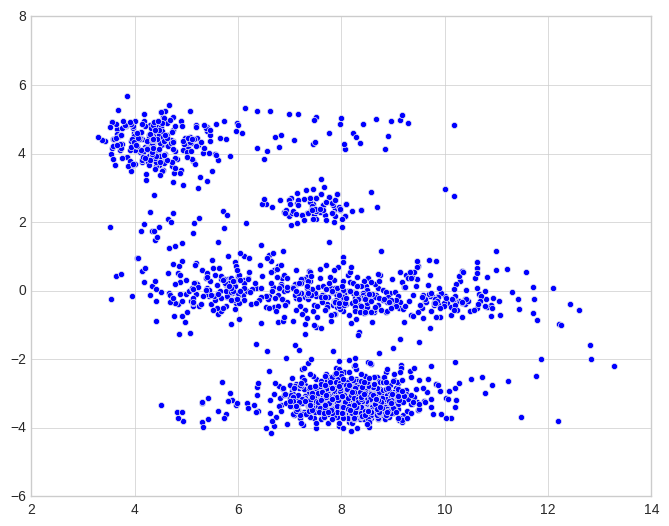

In [278]:
plt.scatter(features_eq["Lig900-C9 to Ala240"].iloc[::10], features_eq["mOR tIC.4"].iloc[::10])

In [1086]:
node_prs = [(node, pr) for node, pr in pr.items()]
pr_df = pd.DataFrame(node_prs, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import standardize_df
pr_df = pr_df.loc[~pr_df.feature.str.contains("BU")]
pr_df = standardize_df(pr_df, columns=["importance"])
#pr_df = pr_df.loc[pr_df.feature.str.contains("<")]
pr_df.iloc[:100]
#pr_df.loc[pr_df.feature.str.contains("Gln")].iloc[:100]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
366,ILE256_CA to LEU275_CA < 9.368478,4.286725
338,8.597809 < PHE289 to TYR336 < 11.662846,3.615223
1077,TYR336_CA to VAL286_CA < 11.893261,3.383426
633,tm6_tm5_packing < 9.597138,2.941627
769,mOR tIC.1 < -0.077858,2.885062
994,9.207879 < LYS233_CA to LYS303_CA < 12.707335,2.881426
990,ILE301_CA to PHE237_CA < 7.377830,2.848049
153,7.084244 < PHE289 to PRO244 < 10.426378,2.830933
743,rmsd_triad_active < 1.535796,2.681111
1118,PHE289 to PRO244 < 7.084244,2.670394


In [ ]:
#tent_df.loc[[n for n in df.index.values.tolist() if ("bu" in n.lower()) and "tm6_tm3_packing" in n]].sort("importance", inplace=False, ascending=False).iloc[:10]

In [697]:
top_tuples = tent_df.loc[tent_df.importance > 1e-2]["tuples"].values.tolist()

[(46, 1158), (47, 1158), (47, 1159), (46, 1159), (47, 1140), (46, 1140), (46, 1386), (47, 1386), (46, 1387), (47, 1387)]
114036


In [ ]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *


top_tentropy_array, top_tentropy_pairs_id_tuples, top_tentropy_pairs_names = compute_tentropy_between(list(zip(timeseries_i, timeseries_j)), lag_time=5,
                                                                                         titles_i=titles_i, titles_j=titles_j, n_shuffle=25, worker_pool=dview,
                                                                                         parallel=False, i_j_pairs=top_tuples)




(114036,)


In [245]:
top_tent_df_file = "%s/bu72_tent_top_df_subtracted.pkl" %traj_dir
if not os.path.exists(top_tent_df_file):
    top_tent_df = get_tentropy_df(top_tentropy_array, top_tentropy_pairs_id_tuples, top_tentropy_pairs_names, top_tent_df_file)
else:
    with open(top_tent_df_file, "rb") as f:
        top_tent_df = pickle.load(f)

In [177]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

top_tent_df = process_tent_df(top_tent_df, old_ligand_name="Lig900", new_ligand_name="BU72", worker_pool=None, parallel=False)

About to process TEntropy DF
Processing TEntropy DF
Removing bad entries.
Finished looping through all feature pairs. Making DF...


In [178]:
top_tent_df.shape

(110960, 4)

In [954]:
top_tent_df.loc[top_tent_df.index.str.contains("LEU88 to PHE338")]

,importance,tuples,feature_i,feature_j
"('LEU88 to PHE338 < 6.938289', 'LEU158_CA to VAL285_CA < 10.704645')",0.0333198,"(1349, 978)",LEU88 to PHE338 < 6.938289,LEU158_CA to VAL285_CA < 10.704645
"('LEU88 to PHE338 < 6.938289', '5.226066 < ALA304_CA to ASN230_CA < 8.378788')",0.0332551,"(1349, 1183)",LEU88 to PHE338 < 6.938289,5.226066 < ALA304_CA to ASN230_CA < 8.378788
"('LEU88 to PHE338 < 6.938289', 'BU72-C3 to Tyr326 > 5.000000')",0.0319482,"(1349, 623)",LEU88 to PHE338 < 6.938289,BU72-C3 to Tyr326 > 5.000000
"('LEU88 to PHE338 < 6.938289', '3.000000 < BU72-C3 to Tyr326 < 5.000000')",0.0319474,"(1349, 622)",LEU88 to PHE338 < 6.938289,3.000000 < BU72-C3 to Tyr326 < 5.000000
"('LEU88 to PHE338 < 6.938289', 'LEU339_CA to VAL334_CA < 7.588126')",0.03181,"(1349, 1341)",LEU88 to PHE338 < 6.938289,LEU339_CA to VAL334_CA < 7.588126
"('LEU88 to PHE338 < 6.938289', 'LEU339_CA to VAL282_CA < 9.718724')",0.0301112,"(1349, 1046)",LEU88 to PHE338 < 6.938289,LEU339_CA to VAL282_CA < 9.718724
"('LEU88 to PHE338 < 6.938289', '3.000000 < BU72-C18 to Tyr326 < 5.000000')",0.0298339,"(1349, 244)",LEU88 to PHE338 < 6.938289,3.000000 < BU72-C18 to Tyr326 < 5.000000
"('LEU88 to PHE338 < 6.938289', 'BU72-C18 to Tyr326 > 5.000000')",0.0297981,"(1349, 245)",LEU88 to PHE338 < 6.938289,BU72-C18 to Tyr326 > 5.000000
"('LEU88 to PHE338 < 6.938289', '15.297292 < PHE338_CA to PHE84_CA < 16.883787')",0.0294573,"(1349, 1251)",LEU88 to PHE338 < 6.938289,15.297292 < PHE338_CA to PHE84_CA < 16.883787
"('LEU88 to PHE338 < 6.938289', 'BU72-O1 to His297 > 5.000000')",0.028842,"(1349, 920)",LEU88 to PHE338 < 6.938289,BU72-O1 to His297 > 5.000000


In [ ]:
#df.loc[[n for n in df.index.values.tolist() if "lig" in n.lower() or "bu" in n.lower() and "tm6_tm3_packing" in n]].iloc[:30]

In [218]:
top_tent_df.iloc[:10]

,importance,tuples,feature_i,feature_j
"('ILE308_CA to TRP318_CA < 12.927590', 'PRO309_CA to THR315_CA > 9.575751')",0.101473,"(1222, 1242)",ILE308_CA to TRP318_CA < 12.927590,PRO309_CA to THR315_CA > 9.575751
"('ILE308_CA to TRP318_CA < 12.927590', '5.801102 < PRO309_CA to THR315_CA < 9.575751')",0.10136,"(1222, 1241)",ILE308_CA to TRP318_CA < 12.927590,5.801102 < PRO309_CA to THR315_CA < 9.575751
"('ILE308_CA to TYR299_CA > 13.165740', 'ILE308_CA to TRP318_CA < 12.927590')",0.0949608,"(1045, 1222)",ILE308_CA to TYR299_CA > 13.165740,ILE308_CA to TRP318_CA < 12.927590
"('TRP293-CG to PHE289-CG: Pi T < 0.507538', 'ALA240 to TRP293 < 4.264226')",0.0940034,"(1441, 1170)",TRP293-CG to PHE289-CG: Pi T < 0.507538,ALA240 to TRP293 < 4.264226
"('BU72-C4 to Ile322 > 5.000000', 'BU72-O2 to Ile322 > 5.000000')",0.0935791,"(638, 968)",BU72-C4 to Ile322 > 5.000000,BU72-O2 to Ile322 > 5.000000
"('3.000000 < BU72-C4 to Ile322 < 5.000000', 'BU72-O2 to Ile322 > 5.000000')",0.0935791,"(637, 968)",3.000000 < BU72-C4 to Ile322 < 5.000000,BU72-O2 to Ile322 > 5.000000
"('BU72-C4 to Ile322 > 5.000000', '3.000000 < BU72-O2 to Ile322 < 5.000000')",0.0935791,"(638, 967)",BU72-C4 to Ile322 > 5.000000,3.000000 < BU72-O2 to Ile322 < 5.000000
"('3.000000 < BU72-C4 to Ile322 < 5.000000', '3.000000 < BU72-O2 to Ile322 < 5.000000')",0.093564,"(637, 967)",3.000000 < BU72-C4 to Ile322 < 5.000000,3.000000 < BU72-O2 to Ile322 < 5.000000
"('3.000000 < BU72-C4 to Met151 < 5.000000', 'BU72-C8 to Val236 > 5.000000')",0.0923378,"(640, 806)",3.000000 < BU72-C4 to Met151 < 5.000000,BU72-C8 to Val236 > 5.000000
"('BU72-C4 to Met151 > 5.000000', '3.000000 < BU72-C8 to Val236 < 5.000000')",0.0923288,"(641, 805)",BU72-C4 to Met151 > 5.000000,3.000000 < BU72-C8 to Val236 < 5.000000


In [224]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

causality_graph_file = "%s/causality_graph_top30k_cutoff6e-2.graphml" %analysis_dir
causality_graph_file_transpose = "%s/causality_graph_top30k_cutoff6e-2_transpose.graphml" %analysis_dir
top_causality_graph, top_causality_graph_transpose = build_causality_network(top_tent_df, causality_graph_file, 6e-2, "BU72", log=False, save_transpose=True, transpose_file=causality_graph_file_transpose)
print(len(top_causality_graph.nodes()))
print(len(top_causality_graph.edges()))

397
14055


In [216]:
causality_graph_file

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time/causality_graph_top30k_cutoff5e-2.graphml'

In [180]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

lig_nodes = [l for l in top_causality_graph.nodes() if "bu" in l.lower()]
target = [l for l in top_causality_graph.nodes() if "tm6_tm3_packing" in l][0]


Done computing paths. Merging dictionaries now.
3.000000 < BU72-C8 to Lys233 < 5.000000
BU72-N1 to Met151 > 5.000000
3.000000 < BU72-C7 to Tyr148 < 5.000000
3.000000 < BU72-C11 to Ile296 < 5.000000
TRP293 to TYR326 < 7.278375
BU72-C18 to Ile322 > 5.000000
9.518119 < ILE301_CA to VAL236_CA < 13.876572
3.000000 < BU72-C27 to Tyr148 < 5.000000
3.000000 < BU72-C1 to Tyr148 < 5.000000
3.000000 < BU72-C26 to Trp133 < 5.000000
BU72-C3 to Trp293 > 5.000000
BU72-C8 to Trp318 > 5.000000
BU72-C26 to Trp318 > 5.000000
BU72-C26 to Tyr148 > 5.000000
3.000000 < BU72-C12 to Tyr148 < 5.000000
BU72-C28 to Val143 > 5.000000
3.000000 < BU72-C15 to Val300 < 5.000000
LYS233_CA to TYR148_CA < 12.440344
3.000000 < BU72-C8 to Val236 < 5.000000
TYR336_CA to VAL285_CA < 10.505933
3.000000 < BU72-C17 to Tyr326 < 5.000000
3.000000 < BU72-C11 to Val300 < 5.000000
BU72-C16 to Ile322 > 5.000000
BU72-C25 to Lys233 > 5.000000
BU72-C23 to Leu219 > 5.000000
3.000000 < BU72-C23 to Trp318 < 5.000000
3.000000 < BU72-C17 to 

/vspdata/vspcompute/home/enf/software/mdentropy/mdentropy/examples/transfer_entropy_analysis.py:315: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  feature_importances = pd.DataFrame(feature_importances, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
/vspdata/vspcompute/home/enf/software/mdentropy/mdentropy/examples/transfer_entropy_analysis.py:318: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  path_importances = pd.DataFrame(path_importances, columns=["path", "importance"]).sort("importance", ascending=False, inplace=False)


In [183]:
top_tm6_paths = "%s/bu72_top_tm6_paths.pkl" %traj_dir
#if not os.path.exists(top_tm6_paths):
if 1==1:
    tent_feature_df, tent_path_df = compute_sources_target_importances(graph=causality_graph, sources=lig_nodes, target=target,
                                                                                  k=1000, weight="inverse_weight", worker_pool=dview, parallel=False)
    with open(top_tm6_paths, "wb") as f:
        pickle.dump((tent_feature_df, tent_path_df), f)
else:
    with open(top_tm6_paths, "rb") as f:
        tent_feature_df, tent_path_df = pickle.load(f)

In [1006]:
ref_features["Lig900-C28 to Gln124"]

0    6.104794
1    4.107214
Name: Lig900-C28 to Gln124, dtype: float32

In [185]:
sub_df = tent_feature_df.loc[(~tent_feature_df.feature.str.contains("BU")) & (tent_feature_df.feature.str.contains(""))]# & (tent_feature_df.feature.str.contains("<"))]# & (tent_feature_df.feature.str.contains("<"))]
#sub_df.index = sub_df.feature
#sub_df = pd.concat([sub_df, get_xtal_vals(sub_df.feature.values.tolist())], axis=1, join='outer').sort("importance", inplace=False, ascending=False)
sub_df.iloc[:100]

,feature,importance
529,tm6_tm3_packing < 10.647170,21.017786
464,tm6_tm5_packing < 9.597138,4.533475
360,ILE256_CA to LEU275_CA < 9.368478,3.400856
252,rmsd_DRY_inactive < 2.882904,2.085940
313,6.616499 < ARG165_CA to THR279_CA < 10.267918,1.128451
467,ARG165_CA to THR279_CA > 10.267918,1.114619
98,5.801102 < PRO309_CA to THR315_CA < 9.575751,0.673241
117,PRO309_CA to THR315_CA > 9.575751,0.670584
579,5.226066 < ALA304_CA to ASN230_CA < 8.378788,0.555529
226,ALA304_CA to ASN230_CA < 5.226066,0.458620


In [170]:
tent_feature_df.iloc[:100]

,feature,importance
317,tm6_tm3_packing < 10.647170,1.530423
516,tm6_tm5_packing < 9.597138,0.175857
430,6.616499 < ARG165_CA to THR279_CA < 10.267918,0.099904
480,ILE256_CA to LEU275_CA < 9.368478,0.099082
226,ARG165_CA to THR279_CA > 10.267918,0.095326
268,rmsd_DRY_inactive < 2.882904,0.086796
436,BU72-O1 to His297 > 5.000000,0.063184
61,BU72-C10 to Met151 > 5.000000,0.058587
603,3.000000 < BU72-C10 to Met151 < 5.000000,0.058572
621,3.000000 < BU72-C15 to Ile322 < 5.000000,0.057653


In [1066]:
tent_path_names = tent_path_df.path
tent_path_df.index = tent_path_df.path
tent_path_df.loc[[n for n in tent_path_names if "tm6_tm3" not in n[1] and "rmsd" not in n[1] and "packing" not in n[1] and "BU" not in n[1] and "ILE256" not in n[1] and "ARG165_CA to THR279" not in n[1] and "Gln124" in n[0]][:100]]

,path,importance
path,,
"(BU72-C25 to Gln124 > 5.000000, 5.801102 < PRO309_CA to THR315_CA < 9.575751, tm6_tm3_packing < 10.647170)","(BU72-C25 to Gln124 > 5.000000, 5.801102 < PRO309_CA to THR315_CA < 9.575751, tm6_tm3_packing < ...",0.001363
"(BU72-C25 to Gln124 > 5.000000, PRO309_CA to THR315_CA > 9.575751, tm6_tm3_packing < 10.647170)","(BU72-C25 to Gln124 > 5.000000, PRO309_CA to THR315_CA > 9.575751, tm6_tm3_packing < 10.647170)",0.001362
"(3.000000 < BU72-C25 to Gln124 < 5.000000, 5.801102 < PRO309_CA to THR315_CA < 9.575751, tm6_tm3_packing < 10.647170)","(3.000000 < BU72-C25 to Gln124 < 5.000000, 5.801102 < PRO309_CA to THR315_CA < 9.575751, tm6_tm3...",0.001306
"(3.000000 < BU72-C25 to Gln124 < 5.000000, PRO309_CA to THR315_CA > 9.575751, tm6_tm3_packing < 10.647170)","(3.000000 < BU72-C25 to Gln124 < 5.000000, PRO309_CA to THR315_CA > 9.575751, tm6_tm3_packing < ...",0.001304
"(3.000000 < BU72-C27 to Gln124 < 5.000000, ALA113_CA to ILE146_CA < 9.446390, tm6_tm3_packing < 10.647170)","(3.000000 < BU72-C27 to Gln124 < 5.000000, ALA113_CA to ILE146_CA < 9.446390, tm6_tm3_packing < ...",0.001261
"(BU72-C26 to Gln124 > 5.000000, TYR336_CA to VAL286_CA < 11.893261, tm6_tm3_packing < 10.647170)","(BU72-C26 to Gln124 > 5.000000, TYR336_CA to VAL286_CA < 11.893261, tm6_tm3_packing < 10.647170)",0.001227
"(3.000000 < BU72-C26 to Gln124 < 5.000000, TYR336_CA to VAL286_CA < 11.893261, tm6_tm3_packing < 10.647170)","(3.000000 < BU72-C26 to Gln124 < 5.000000, TYR336_CA to VAL286_CA < 11.893261, tm6_tm3_packing <...",0.001224
"(3.000000 < BU72-C24 to Gln124 < 5.000000, PRO309_CA to THR315_CA > 9.575751, tm6_tm3_packing < 10.647170)","(3.000000 < BU72-C24 to Gln124 < 5.000000, PRO309_CA to THR315_CA > 9.575751, tm6_tm3_packing < ...",0.001201
"(3.000000 < BU72-C24 to Gln124 < 5.000000, 5.801102 < PRO309_CA to THR315_CA < 9.575751, tm6_tm3_packing < 10.647170)","(3.000000 < BU72-C24 to Gln124 < 5.000000, 5.801102 < PRO309_CA to THR315_CA < 9.575751, tm6_tm3...",0.001200


In [186]:
pr = nx.pagerank(top_causality_graph, weight="weight")
pr_t = nx.pagerank(top_causality_graph_transpose, weight="weight")

hubs, authorities = nx.hits(top_causality_graph)

eigs = nx.eigenvector_centrality(top_causality_graph)


#hubs_t, authorities_t = nx.hits(top_causality_graph_transpose)



In [191]:
node_prs = [(node, pr) for node, pr in pr_t.items()]
pr_df = pd.DataFrame(node_prs, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import standardize_df
pr_df = pr_df.loc[pr_df.feature.str.contains("BU")]
pr_df = standardize_df(pr_df, columns=["importance"])
pr_df = pr_df.loc[pr_df.feature.str.contains("<")]
pr_df.iloc[:100]
#pr_df.loc[pr_df.feature.str.contains("Gln")].iloc[:100]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
384,3.000000 < BU72-C15 to Ile322 < 5.000000,2.452111
5,3.000000 < BU72-C1 to Tyr148 < 5.000000,2.382987
619,3.000000 < BU72-C3 to Tyr326 < 5.000000,2.237682
820,3.000000 < BU72-C9 to Val236 < 5.000000,2.121300
353,3.000000 < BU72-O1 to Ile296 < 5.000000,2.082282
564,3.000000 < BU72-C9 to Met151 < 5.000000,2.068639
10,3.000000 < BU72-C8 to Val236 < 5.000000,2.042145
90,3.000000 < BU72-C7 to Met151 < 5.000000,2.038736
206,3.000000 < BU72-O1 to Val236 < 5.000000,2.036433
222,3.000000 < BU72-C21 to Tyr326 < 5.000000,2.033704


In [74]:
def get_xtal_vals(feature_list):
    df = pd.concat([ref_features, new_ref_df], axis=1)
    ref_feature_names = df.columns.values.tolist()
    
    final_names = []
    full_final_names = []
    for feature in feature_list:
        ori_feature = get_ori_feature_name(feature)
        if ori_feature in ref_feature_names:
            final_names.append(ori_feature)
            full_final_names.append(feature)
    xtal_vals = df[final_names].transpose()
    xtal_vals.columns = ["Inactive Crystal", "Active Crystal"]
    xtal_vals.index = full_final_names
    return(xtal_vals)

In [1268]:
pr = nx.pagerank(top_causality_graph, weight="weight")
pr_t = nx.pagerank(top_causality_graph, weight="weight")

hubs, authorities = nx.hits(top_causality_graph)

#eigs = nx.eigenvector_centrality(top_causality_graph)
#hubs_t, authorities_t = nx.hits(top_causality_graph_transpose)

In [1319]:
protein_subgraph = top_causality_graph.subgraph([n for n in top_causality_graph.nodes() if "BU" not in str(n)])
print(list(protein_subgraph.nodes()))
pr = nx.pagerank(protein_subgraph.reverse(), weight="weight")
pr_t = nx.pagerank(protein_subgraph.reverse(), weight="weight")

hubs, authorities = nx.hits(protein_subgraph.reverse())

#eigs = nx.eigenvector_centrality(top_causality_graph)
#hubs_t, authorities_t = nx.hits(top_causality_graph_transpose)

['ASN328_CA to ILE155_CA < 10.962412', '5.861956 < GLN314 to TYR299 < 7.954842', '13.493068 < ILE322_CA to VAL78_CA < 14.109294', 'LEU339_CA to VAL334_CA < 7.588126', 'CYS330_CA to GLY82_CA < 5.650008', 'SER329_CA to VAL81_CA < 11.866833', 'LEU339 to VAL334 < 4.305421', '9.769920 < TYR326_CA to VAL78_CA < 11.381454', 'PHE289_CA to PRO244_CA < 10.813179', '8.378788 < ALA304_CA to ASN230_CA < 10.302482', 'ALA68 to TYR128 < 5.874669', '8.398401 < TYR326_CA to VAL78_CA < 9.084160', '6.616499 < ARG165_CA to THR279_CA < 10.267918', 'rmsd_npxxy_active < 0.387066', 'mOR tIC.10 < -1.451800', 'PHE123_CA to PHE135_CA < 11.333636', '11.798966 < PRO333_CA to VAL81_CA < 13.978399', 'ALA304_CA to LYS233_CA < 6.975143', '7.004213 < PRO333_CA to VAL81_CA < 11.798966', 'tm6_tm3_packing < 10.647170', '6.975143 < ALA304_CA to LYS233_CA < 13.073434', 'rmsd_npxxy_inactive < 0.477678', 'tm6_tm7_packing < 13.812441', 'HIS297 to VAL236 < 8.454900', '5.405670 < LEU129 to MET72 < 5.944122', 'TRP293_CA to VAL288_

In [1420]:
node_prs = [(node, pr) for node, pr in authorities.items()]
pr_df = pd.DataFrame(node_prs, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
pr_df.index = pr_df.feature
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import standardize_df
pr_df = pr_df.loc[pr_df.feature.str.contains("BU")]
pr_df = standardize_df(pr_df, columns=["importance"])
#pr_df = pd.concat([pr_df, get_xtal_vals(pr_df.feature.values.tolist())], axis=1, join='outer').sort("importance", inplace=False, ascending=False)
#pr_df = pr_df.loc[pr_df.feature.str.contains("<")]
pr_df.iloc[:100]
#pr_df.loc[pr_df.feature.str.contains("Gln")].iloc[:100]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
feature,,
3.000000 < BU72-C27 to Trp133 < 5.000000,3.000000 < BU72-C27 to Trp133 < 5.000000,2.212348
BU72-C27 to Trp133 > 5.000000,BU72-C27 to Trp133 > 5.000000,2.212339
BU72-C8 to Val300 > 5.000000,BU72-C8 to Val300 > 5.000000,2.159251
3.000000 < BU72-C8 to Val300 < 5.000000,3.000000 < BU72-C8 to Val300 < 5.000000,2.159097
3.000000 < BU72-C9 to His297 < 5.000000,3.000000 < BU72-C9 to His297 < 5.000000,2.033639
BU72-C9 to His297 > 5.000000,BU72-C9 to His297 > 5.000000,1.999381
BU72-C26 to Cys217 > 5.000000,BU72-C26 to Cys217 > 5.000000,1.971795
3.000000 < BU72-C26 to Cys217 < 5.000000,3.000000 < BU72-C26 to Cys217 < 5.000000,1.959527
3.000000 < BU72-C10 to Tyr148 < 5.000000,3.000000 < BU72-C10 to Tyr148 < 5.000000,1.889037


In [1262]:
df = pd.DataFrame([(key, value['weight']) for key, value in top_causality_graph['3.000000 < BU72-C27 to Trp133 < 5.000000'].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
#df = pd.DataFrame([(key, value['weight']) for key, value in top_causality_graph["LYS233_CA to LYS303_CA < 9.207879"].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
df.loc[~df.edge.str.contains("BU")]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,edge,weight
188,ALA240 to TRP293 < 4.264226,0.065049
296,3.599943 < ASP147 to TYR326 < 8.476539,0.064510
134,ASP147 to TYR326 < 3.599943,0.063751
194,ARG277_CA to GLU341_CA < 10.444098,0.050179
138,5.418783 < ALA304 to ASN230 < 6.773805,0.047160
163,ILE301_CA to PHE237_CA < 7.377830,0.046307
288,VAL236_CA to VAL300_CA < 9.287251,0.045739
71,9.287251 < VAL236_CA to VAL300_CA < 14.469413,0.044815
72,ALA304 to ASN230 < 5.418783,0.043690
131,LYS233_CA to LYS303_CA < 9.207879,0.043406


In [1109]:
[(key, value['weight']) for key, value in top_causality_graph["LYS233_CA to LYS303_CA < 9.207879"].items()]

[('BU72-N1 to Met151 > 5.000000', 0.039038369816467466),
 ('BU72-C19 to Ile322 > 5.000000', 0.052270880834342795),
 ('BU72-C28 to Gln124 > 5.000000', 0.044154691710254074),
 ('3.000000 < BU72-C6 to Met151 < 5.000000', 0.05748734625059926),
 ('BU72-C12 to Met151 > 5.000000', 0.046576711192403066),
 ('3.000000 < BU72-C4 to Ile296 < 5.000000', 0.05584805390681269),
 ('3.000000 < BU72-C26 to Gln124 < 5.000000', 0.03768791373570673),
 ('8.688042 < ARG280_CA to PHE338_CA < 12.481794', 0.031297612415663284),
 ('BU72-O1 to Ile296 > 5.000000', 0.06201280488025138),
 ('3.000000 < BU72-C4 to Gly325 < 5.000000', 0.0334487996013026),
 ('BU72-C8 to Lys233 > 5.000000', 0.0377086597808755),
 ('3.000000 < BU72-C26 to Trp318 < 5.000000', 0.033618409058396206),
 ('BU72-C10 to Met151 > 5.000000', 0.05435914000580127),
 ('3.000000 < BU72-C10 to Val236 < 5.000000', 0.05209152044524673),
 ('BU72-C7 to Met151 > 5.000000', 0.06339859417120433),
 ('LEU339 to VAL334 < 4.305421', 0.029341955406319793),
 ('3.00000

In [530]:
subgraph_file = "%s/subgraph_tm6_tm3_target.graphml" %analysis_dir
extract_paths_from_gr]aph(top_causality_graph, path_df, importance_cutoff=1e-3, graph_file=subgraph_file)

In [ ]:
reload(matplotlib)
r2_scores_df = pd.Series(scores, index=y.columns).sort(ascending=False, inplace=False)
r2_scores_df = r2_scores_df.loc[r2_scores_df > 0.]
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title, figsize=(5,10))
plt.xlabel("Average Test ROC AUC")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_oneshot_%s.pdf" %(analysis_dir, title))
plt.show()

In [ ]:
r2_scores_df

In [ ]:
"%s/all_features_oneshot_%s.pdf" %(analysis_dir, title)

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

In [ ]:
if not os.path.exists("%s/all_features_multionehot_rfr_scores.h5" %analysis_dir):
    scores, importances = compute_rf_matrix(x.values, y_classified.values, n_trees=500, max_depth=3, n_folds=5, task="regression")
    verbosedump(scores, "%s/all_features_multionehot_classified_rfr_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/all_features_multionehot_classified_rfr_importances.h5" %analysis_dir)
else:
    scores = compat_verboseload("%s/all_features_multionehot_classified_rfr_scores.h5" %analysis_dir)
    importances = compat_verboseload("%s/all_features_multionehot_classified_rfr_importances.h5" %analysis_dir)

#if not os.path.exists("%s/all_features_rfr_r2_scores.h5" %analysis_dir):
#    print("hi")
#r2_scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
#verbosedump(r2_scores, "%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#verbosedump(importances, "%s/all_features_rfr_importances.h5" %analysis_dir)
#else:
#r2_scores = compat_verboseload("%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#importances = compat_verboseload("%s/all_features_rfr_importances.h5" %analysis_dir)

In [ ]:
scores_df = pd.Series(scores, index=y.columns)
scores_df.sort(inplace=False)

In [ ]:
#pearson_matrix = compute_pearson_matrix(x.values, y.values)
#pearson_df = pd.DataFrame(pearson_matrix, columns=y.columns, index=x.columns)
pearson_df["tm6_tm3_packing"].abs().sort(inplace=False)

In [ ]:
importances_df = pd.DataFrame(importances, columns=y_classified.columns, index=x.columns)
#importances_df["mOR tIC.5"].loc[[n for n in importances_df.index.values.tolist()]].abs().sort(inplace=False, ascending=False)
#importances_df["PHE289 to ASN150"].abs().sort(inplace=False, ascending=False).iloc[:100]
df = importances_df["MET281_CA to MET161_CA"].abs().sort(inplace=False, ascending=False)
df.loc[[n for n in df.index.values.tolist() if "<" in n]]


In [ ]:
plt.clf()
plt.hist(pd.concat(all_traj_features,axis=0)["PHE289 to ASN150"].values, bins=50)
plt.show()

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
feature = "TYR336 to PHE289"
plt.clf()
#for i in range(0,100):
#    if "Tyr326" in df.index.values[i]:
data_i = y.loc[features_eq["Lig900-N1 to Tyr326"] < 5.][feature].values
data_j = y.loc[features_eq["Lig900-N1 to Tyr326"] > 5.][feature].values
        #data_i = y.loc[x[df.index.values[i]] == 1.][feature].values
        #data_j = y.loc[x[df.index.values[i]] == 0.][feature].values
        #if len(np.where(data > 10.)[0]) < 5*len(np.where(data < 10.)[0]): continue
        #if len(np.where(data > 10.)[0]) < 150: continue
title_i = df.index.values[i].replace("Lig900", "BU72")
title_j = "Not %s" %df.index.values[i].replace("Lig900", "BU72")
        #compute_and_plot_single_kde(data_i, title_i, 
        #                            "Phe289 to Asn150 Distance, Angstroms", "%s/%s.pdf" %(analysis_dir,title_i), custom_bounds=[5,16], custom_y_bounds=[0,.6])
        #compute_and_plot_single_kde(data_j, title_j, 
        #                            "Phe289 to Asn150 Distance, Angstroms", "%s/%s.pdf" %(analysis_dir,title_j), custom_bounds=[5,16], custom_y_bounds=[0,.6])
compute_and_plot_kde_difference(data_i, data_j, title_i, "%s Distance, Angstroms" %feature, "%s/%s_difference.pdf" %(analysis_dir,title_i), custom_bounds=[5,16], custom_y_bounds=[-.4,.4])
        

In [ ]:
y_classified["tm6_tm3_packing"]

In [ ]:
plt.scatter(features_eq["Lig900-N1 to Tyr326"].iloc[::10], features_eq["tm6_tm3_packing"].iloc[::10])
plt.show()

In [ ]:
data_i

In [ ]:
analysis_dir

In [ ]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()

#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
#for j in range(0, importances_scaled.shape[1]):
#    importances_scaled[:,j] *= r2_scores[j]

#responses_to_keep = np.where(np.array(r2_scores) > 0.5)[0]
#importances_scaled = importances_scaled[:,responses_to_keep]
#predictors_to_keep = list(set(np.where(importances_scaled > 0.03)[0].tolist()))
#print(responses_to_keep)
#print(predictors_to_keep)
#importances_scaled = importances_scaled[predictors_to_keep,:]
#print(len(responses_to_keep))

row_labels = ["bu72 tIC.%d" %i for i in range(1, n_components+1)]
column_labels = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
#row_labels = x.columns.values[predictors_to_keep]
#column_labels = y.columns.values[responses_to_keep]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/all_features_rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None, xtick_labelsize=8, ytick_labelsize=8)
plt.show()

"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [ ]:
from jointplot_d3 import *
titles_j = [f for f in features_eq.columns.values if "Lig" in f and "Tyr326" in f]
print(titles_j)
jointplots(features_eq[titles_j].values, analysis_dir, titles=titles_j,
                           main = "mOR MSM", refcoords=None, refcoords_j=None, axes=None,
                               data_j=features_eq[["tm6_tm3_packing"]].values, titles_j=["tm6_tm3_packing"], reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

r2_scores

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=2, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    bu72_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(bu72_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["bu72 tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_bu72_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_j, tic_save_dir, titles=lig_features+all_lig_features,
                           main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                               data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=5, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "bu72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "bu72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
protein_ligand_msm_featurized.columns.values.tolist()

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, features_i, features_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=100, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    bu72_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(bu72_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            
            if "PHE289 to ASN150" not in str(features_i[prot_idx]): continue
            
            all_prot_features = [str(features_i[prot_idx])]
            all_lig_features = [str(features_j[lig_idx]) for lig_idx in lig_order[:n_lig_tICs]]
            

            features = []
            prot_features = []
            lig_features = []

            if make_jointplots:
                print("Creating joint deltaG plots.")
                data_i = features_eq[prot_features+all_prot_features].values
                print(data_i.shape)
                data_j = features_eq[lig_features+all_lig_features].values
                print(data_j.shape)

                if ref_df is not None:
                    refcoords = ref_df[prot_features+all_prot_features].values
                    print(refcoords.shape)
                    refcoords_j = ref_df[lig_features+all_lig_features].values
                    print(refcoords_j.shape)
                    combined_refcoords = np.hstack([refcoords, refcoords_j])
                    custom_refcoords = ref_df[custom_features[0]].values
                else:
                    refcoords = None
                    refcoords_j = None
                    combined_refcoords = None
                    custom_refcoords = None

                jointplots(data_i, save_dir, titles=prot_features+all_prot_features,
                       main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8, custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(data_j, save_dir, titles=lig_features + all_lig_features, 
                       main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                           data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(np.hstack([data_i, data_j]), save_dir, titles=prot_features+all_prot_features+lig_features+all_lig_features,
                       main = "mOR MSM", refcoords=combined_refcoords, refcoords_j=custom_refcoords, axes=None,
                           data_j=features_eq[custom_features[0]].values, titles_j=custom_features[0], reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      y.columns, x.columns, n_combs=5,
                                      r2s = np.array(scores), subsample=1, smoothing=100,
                                      n_tICs=20, max_features=1,
                                      #custom_features = None,
                                      custom_features=[[], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "bu72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "bu72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
jointplots_dir

In [ ]:
names

In [ ]:
features_eq[ 'Lig1-C13 to Lys233']

In [ ]:
tpt_paths_features

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None):

    for t, prot_pair in enumerate(prot_pairs):
        if t == n_tICs:
            break
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j = None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [1, 3]
prot_pairs = []
for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
        prot_pairs.append((tics_to_examine[j], tics_to_examine[i]))
print(prot_pairs)
    
make_msm_features_plots_single(importances, protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs)
                                      #tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "bu72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "bu72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

In [183]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(plmf, top_features_per_tIC_i, n_combs=3, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None, alt_features_eq=None, worker_pool=None):

    for t, prot_pair in enumerate(prot_pairs):
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features_i].values, alt_features_eq[features_i].values]))
            custom_lims_j = custom_lim_finder(np.vstack([features_eq[features_j].values, alt_features_eq[features_j].values]))
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=worker_pool, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j, remake=True)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

bu72_jointplots_refcoords_dir = "%s/bu72_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(bu72_jointplots_refcoords_dir):
    os.makedirs(bu72_jointplots_refcoords_dir)
    
apo_jointplots_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [0, 1, 3, 4]
prot_pairs = [(0,3), (3,4), (3, 6), (3, 8), (3,9)]

for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
        prot_pairs.append((tics_to_examine[j], tics_to_examine[i]))

with open("/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/analysis_n_clusters1000_random-1000clusters_25lag-time/suf_features_eq.pkl", "rb") as f:
    suf_features_eq = pickle.load(f)
        
suf_features_eq = suf_features_eq[[c for c in suf_features_eq.columns.values.tolist() if "Lig" not in c]]
bu72_features_eq = features_eq[[c for c in features_eq.columns.values.tolist() if "Lig" not in c]]

"""
make_msm_features_plots_single(None,
                                      bu72_pp_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=pd.concat([apo_features_eq, suf_features_eq], axis=0), worker_pool=None)
                                      #tpt_paths=None)

make_msm_features_plots_single(None,
                                      bu72_pp_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=pd.concat([bu72_features_eq, suf_features_eq], axis=0), worker_pool=None)
                                      #tpt_paths=None)
"""
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "bu72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "bu72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features


#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


'\nmake_msm_features_plots_single(None,\n                                      bu72_pp_tIC_features, n_combs=5,\n                                      subsample=1, smoothing=100,\n                                      n_tICs=10, max_features=1,\n                                      #custom_features = None,\n                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], \n                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,\n                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=pd.concat([apo_features_eq, suf_features_eq], axis=0), worker_pool=None)\n                                      #tpt_paths=None)\n\nmake_msm_features_plots_single(None,\n                                      bu72_pp_tIC_features, n_combs=5,\n                                      subsample=1, smoothing=100,\n          

In [282]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_jointplots(
                            features,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, ref_df=None, save_dir=None,
                            tpt_paths=None, alt_features_eq=None, worker_pool=None, parallel=False,
                            stem_name="", remake=False):

        data_i = features_eq[features].values
        #data_j = features_eq[features].values
        data_j = None
        if ref_df is not None:
            refcoords = ref_df[features].values
            refcoords_j = None
            #refcoords_j = ref_df[features].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features].values, alt_features_eq[features].values]))
            #custom_lims_j = custom_lim_finder(np.vstack([features_eq[features].values, alt_features_eq[features].values]))
            custom_lims_j = None
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, save_dir, titles=features,
                           main=stem_name, refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=worker_pool, parallel=parallel, n_pts=200j, remake=remake)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %pp_tica_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

bu72_jointplots_refcoords_dir = "%s/bu72_refcoords_jointplots_8pt0" %pp_tica_dir
if not os.path.exists(bu72_jointplots_refcoords_dir):
    os.makedirs(bu72_jointplots_refcoords_dir)
    
suf_jointplots_refcoords_dir = "%s/suf_refcoords_jointplots_8pt0" %pp_tica_dir
if not os.path.exists(suf_jointplots_refcoords_dir):
    os.makedirs(suf_jointplots_refcoords_dir)
    
apo_jointplots_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

features_to_examine = ["tm6_tm3_packing", "CYS79 to TYR326", "Lig900-C9 to Ala240"]# "rmsd_npxxy_active", "rmsd_npxxy_inactive","TRP293 to TYR326", "Lig900-C3 to Tyr326", "Lig900-C24 to Gln124"]# "ALA240 to TRP293", "Lig900-N1 to Tyr326", "Lig900-C27 to Gln124", "Lig900-C27 to Trp133", "Lig900-O1 to Trp293", "Lig900-C3 to Trp293", "Lig900-C10 to Met151", "Lig900-C17 to Tyr326", "Lig900-O1 to His297", "Lig900-C21 to Gln124", "Lig900-C7 to Gly325"]    
    
make_jointplots(features_to_examine, 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,
                                      alt_features_eq=None, worker_pool=dview, parallel=False, stem_name="BU72", remake=False)


#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

Making delta G plots.
Done plotting columns


In [286]:
bu72_jointplots_refcoords_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_refcoords_jointplots_8pt0'

we are operating on biox3
plotted


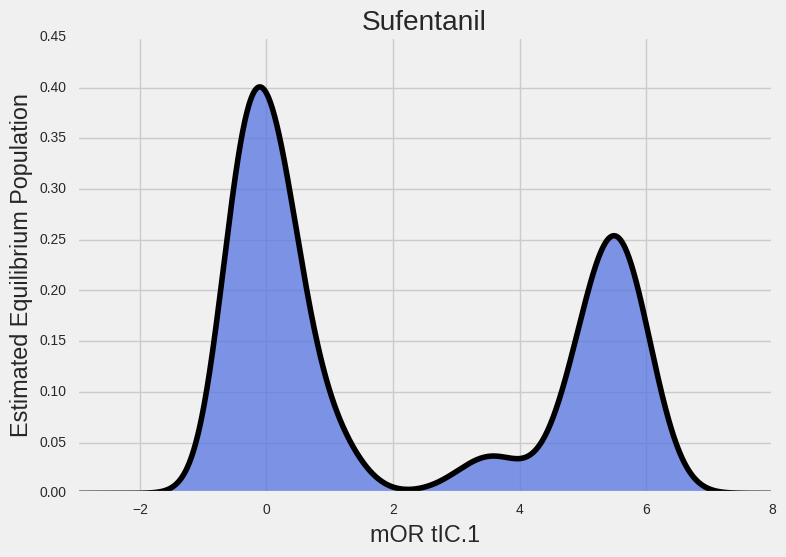

plotted


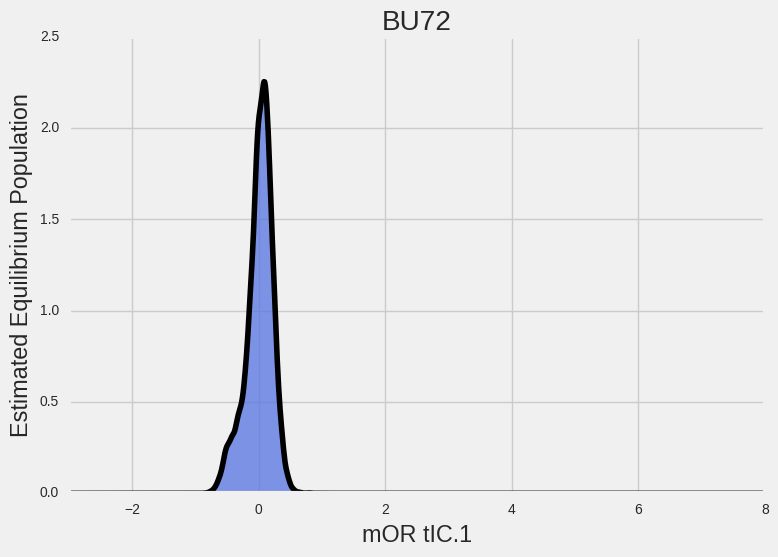

plotted


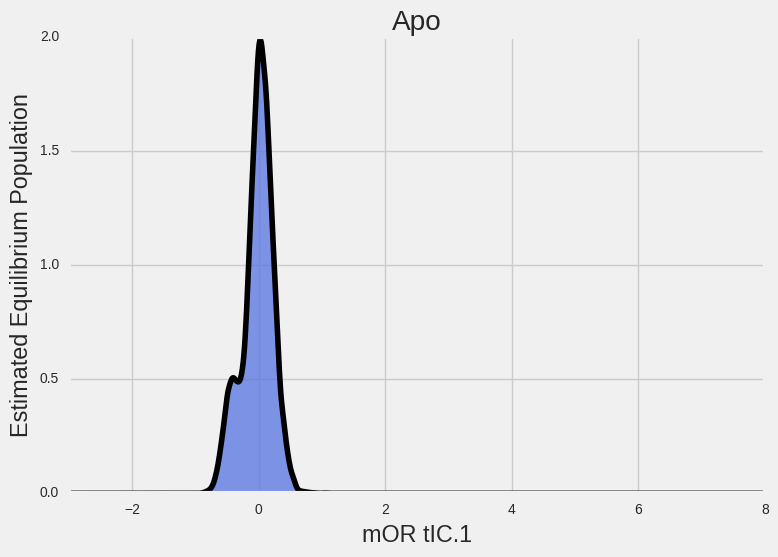

In [195]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *


compute_and_plot_single_kde(suf_features_eq["mOR tIC.1"].values, "Sufentanil", "mOR tIC.1", fig_file=None, custom_bounds=[-3,8], custom_y_bounds=None, n_points=1000)
compute_and_plot_single_kde(bu72_features_eq["mOR tIC.1"].values, "BU72", "mOR tIC.1", fig_file=None, custom_bounds=[-3,8], custom_y_bounds=None, n_points=1000)
compute_and_plot_single_kde(apo_features_eq["mOR tIC.1"].values, "Apo", "mOR tIC.1", fig_file=None, custom_bounds=[-3,8], custom_y_bounds=None, n_points=1000)



#compute_and_plot_single_kde(data, title, xlabel, fig_file=None, custom_bounds=None, custom_y_bounds=None)
#compute_and_plot_single_kde(data, title, xlabel, fig_file=None, custom_bounds=None, custom_y_bounds=None)

In [ ]:
custom_features_4 = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "(HIS319, TYR75)", "bu72 tIC.4", "(Lig900-C7, Tyr75)", "(Lig900-C7, Trp293)"]
make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_4, title="Key Measurements: mOR tIC.4")


In [ ]:
custom_features_2 = ["mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "bu72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]

make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_2, title="Key Measurements: mOR tIC.2")




In [73]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_packing": [(8.0, 10.), (12., 15.)]}#, "ASN150 to PHE289": [(0.,6.5), (9.,15.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in bu72_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            None)

Analyzing tm6_tm3_packing
{'tm6_tm3_packing': [(7, 'bu72_rep_105.h5'), (31, 'bu72_rep_127.h5'), (44, 'bu72_rep_139.h5'), (145, 'bu72_rep_23.h5'), (184, 'bu72_rep_34.h5'), (239, 'bu72_rep_84.h5'), (258, 'bu72_reseeded_rep_100.h5'), (263, 'bu72_reseeded_rep_105.h5'), (278, 'bu72_reseeded_rep_119.h5'), (344, 'bu72_reseeded_rep_179.h5'), (348, 'bu72_reseeded_rep_182.h5'), (350, 'bu72_reseeded_rep_184.h5'), (352, 'bu72_reseeded_rep_186.h5'), (362, 'bu72_reseeded_rep_195.h5'), (412, 'bu72_reseeded_rep_24.h5'), (429, 'bu72_reseeded_rep_255.h5'), (432, 'bu72_reseeded_rep_27.h5'), (441, 'bu72_reseeded_rep_35.h5'), (450, 'bu72_reseeded_rep_43.h5'), (456, 'bu72_reseeded_rep_49.h5'), (459, 'bu72_reseeded_rep_51.h5'), (461, 'bu72_reseeded_rep_53.h5'), (462, 'bu72_reseeded_rep_54.h5'), (463, 'bu72_reseeded_rep_55.h5'), (464, 'bu72_reseeded_rep_56.h5'), (466, 'bu72_reseeded_rep_58.h5'), (467, 'bu72_reseeded_rep_59.h5'), (470, 'bu72_reseeded_rep_61.h5'), (471, 'bu72_reseeded_rep_62.h5'), (472, 'bu72_r

we are operating on biox3


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:496: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=True,window=10).mean()
  pd.rolling_mean(df, smoothing, center=True, min_periods=None)[var].plot(ax=axes[i], linewidth=2.5, title=var, c=c)
/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


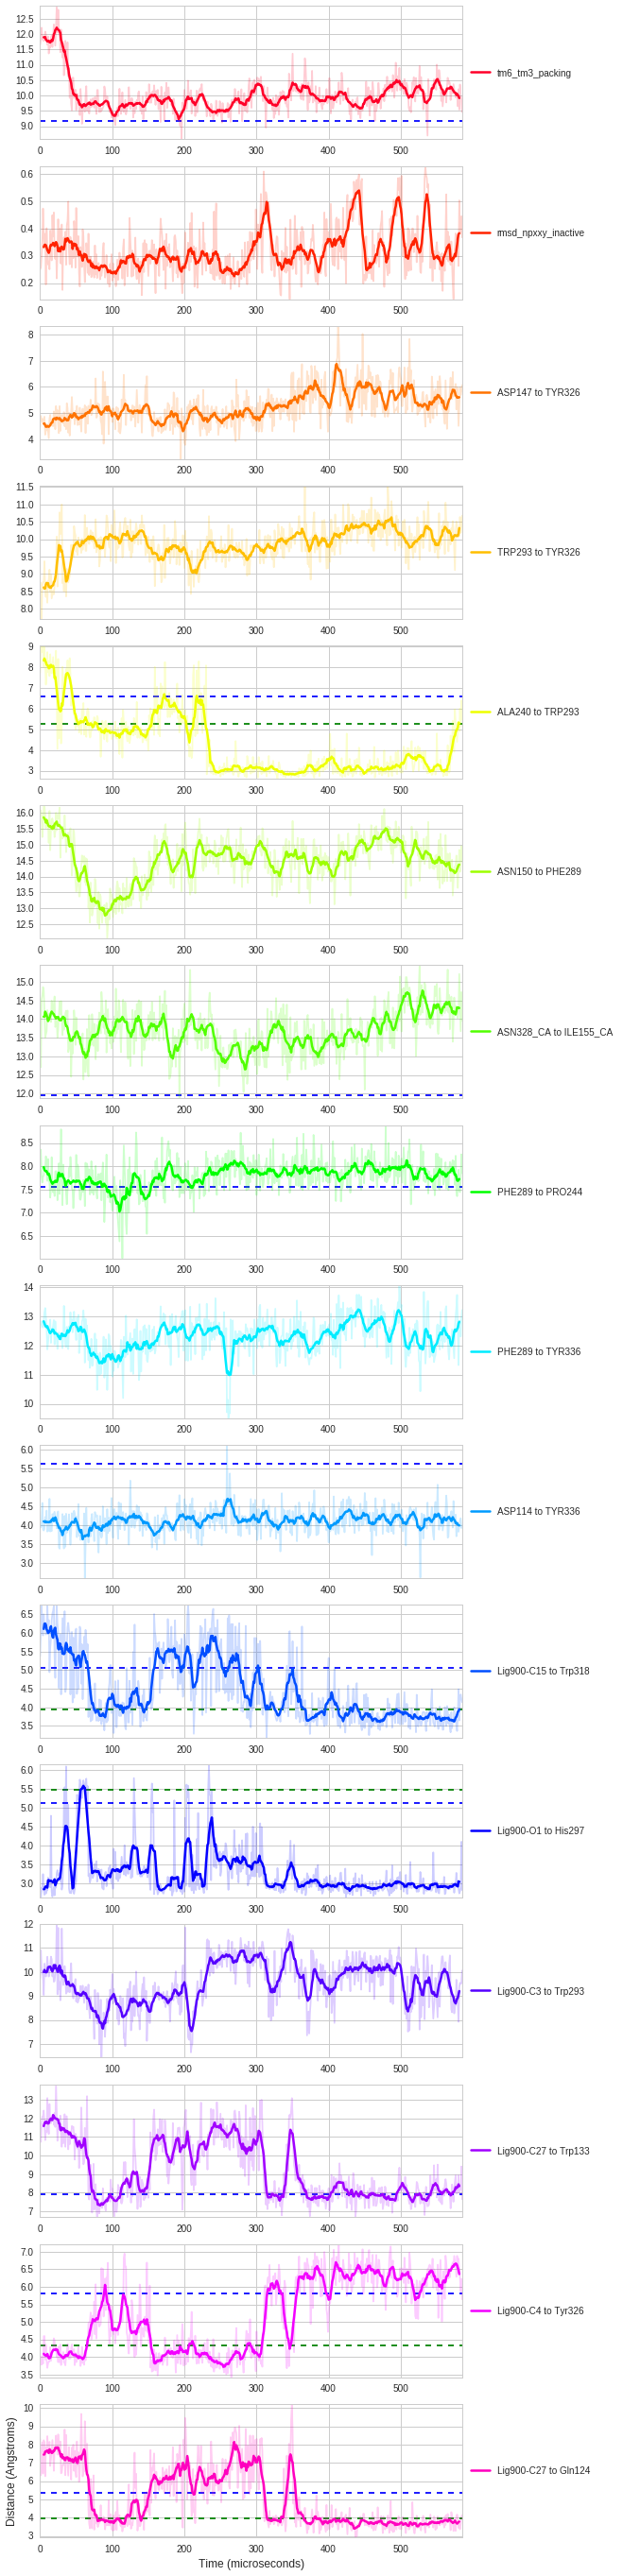

In [76]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
chosen_features = ["tm6_tm3_packing", "rmsd_npxxy_inactive", "ASP147 to TYR326", "TRP293 to TYR326", "ALA240 to TRP293", "ASN150 to PHE289", "ASN328_CA to ILE155_CA", "PHE289 to PRO244", "PHE289 to TYR336",  "ASP114 to TYR336", "Lig900-C15 to Trp318", "Lig900-O1 to His297", "Lig900-C3 to Trp293", "Lig900-C27 to Trp133", "Lig900-C4 to Tyr326", "Lig900-C27 to Gln124"]
intersected_trajs = [t for t in trajs_to_watch["tm6_tm3_packing"]]# [t for t in trajs_to_watch["tm6_tm3_packing"] if t in trajs_to_watch["ASN150 to PHE289"]]
for tup in intersected_trajs:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features[i]
    df = copy.deepcopy(featurized_traj[chosen_features])
    plot_df_rolling(df, "%s/bu72_final_%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=ref_features)

In [288]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
#chosen_features = ["tm6_tm3_packing", "ASP147 to TYR326", "TRP293 to TYR326", "ASN150 to PHE289", "ASN328_CA to ILE155_CA", "PHE289 to PRO244", "PHE289 to TYR336", 
chosen_features =  ["ASP147 to TYR326", "TYR128 to TYR326", "TRP318 to TYR75", "Lig900-C21 to Trp318", "Lig900-O1 to His297", "Lig900-C3 to Trp293", "Lig900-C27 to Trp133", "Lig900-C4 to Tyr326", "Lig900-C27 to Gln124"]
intersected_trajs = [t for t in trajs_to_watch["tm6_tm3_packing"]][:6]# [t for t in trajs_to_watch["tm6_tm3_packing"] if t in trajs_to_watch["ASN150 to PHE289"]]
for tup in intersected_trajs:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features[i]
    df = copy.deepcopy(featurized_traj[chosen_features])
    plot_df_rolling(df.iloc, "%s/bu72_restricted_%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=ref_features, color=None)

we are operating on biox3


AttributeError: '_iLocIndexer' object has no attribute 'columns'

we are operating on biox3


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:501: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=True,window=10).mean()
  


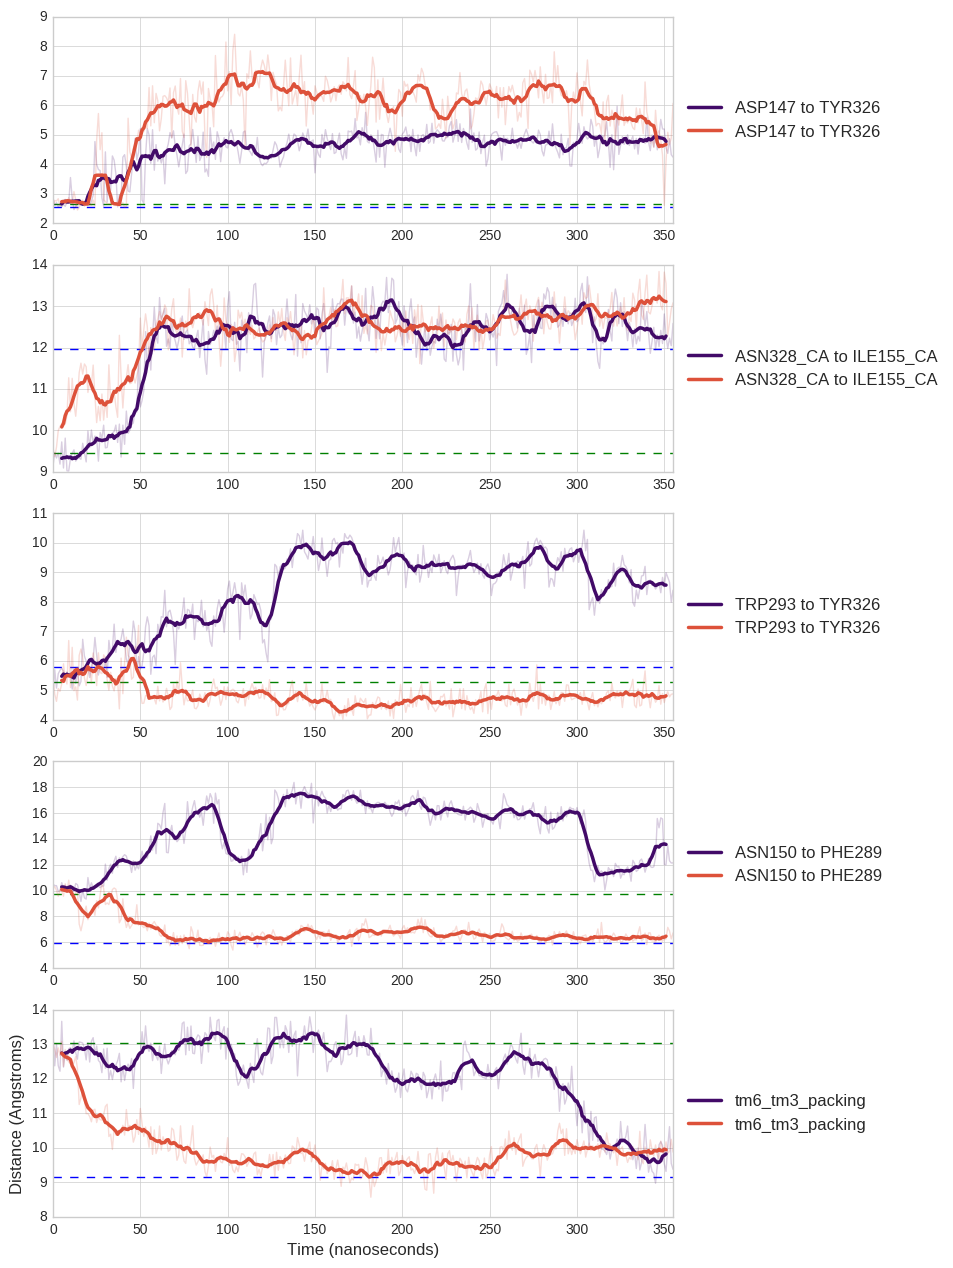

In [342]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
#chosen_features = ["ASP147 to TYR326", "TRP293 to TYR326", "ASN150 to PHE289", "ASN328_CA to ILE155_CA", "tm6_tm3_packing"] 
#chosen_features = ["tm6_tm3_packing", "TRP293 to TYR326", "TYR128 to TYR326", "TRP318 to TYR75", "Lig900-C21 to Trp318", "Lig900-O1 to His297", "Lig900-O1 to His297", "Lig900-C10 to Met151", "Lig900-C3 to Trp293", "Lig900-C27 to Trp133", "Lig900-C4 to Tyr326", "Lig900-C17 to Tyr326", "Lig900-C27 to Gln124", "Lig900-O1 to Trp293"]
chosen_features = ["ASP147 to TYR326", "ASN328_CA to ILE155_CA", "TRP293 to TYR326", "ASN150 to PHE289",  "tm6_tm3_packing"]
#intersected_trajs = [t for t in trajs_to_watch["tm6_tm3_packing"]][:6]# [t for t in trajs_to_watch["tm6_tm3_packing"] if t in trajs_to_watch["ASN150 to PHE289"]]
custom_y_bounds = None
#custom_y_bounds = [(2., 8.), (4., 10.5), (5.5, 18.5), (9, 13.5), (8.5, 13.5), (3., 13)]
featurized_trajs = []
for tup in [(44, 'bu72_rep_139.h5'), (239, 'bu72_rep_84.h5')]: 
#for tup in intersected_trajs:
    i = tup[0]
    name = tup[1]
    featurized_trajs.append(all_traj_features[i][chosen_features])
plot_df_list_rolling(featurized_trajs, "%s/bu72_lp-final_merged_%s.pdf" %(analysis_dir, name), return_fig=True, smoothing=10, include_original=True, ref_df=ref_features, color="RdBu_r", xlabel="Time (nanoseconds)", custom_y_bounds=custom_y_bounds)

In [321]:
intersected_trajs

[(7, 'bu72_rep_105.h5'),
 (31, 'bu72_rep_127.h5'),
 (44, 'bu72_rep_139.h5'),
 (145, 'bu72_rep_23.h5'),
 (184, 'bu72_rep_34.h5'),
 (239, 'bu72_rep_84.h5')]

In [85]:
"""
tm6_tm3_packing < 10.647170	1.530423
516	tm6_tm5_packing < 9.597138	0.175857
430	6.616499 < ARG165_CA to THR279_CA < 10.267918	0.099904
480	ILE256_CA to LEU275_CA < 9.368478	0.099082
226	ARG165_CA to THR279_CA > 10.267918	0.095326
268	rmsd_DRY_inactive < 2.882904	0.086796
436	BU72-O1 to His297 > 5.000000	0.063184
61	BU72-C10 to Met151 > 5.000000	0.058587
603	3.000000 < BU72-C10 to Met151 < 5.000000	0.058572
621	3.000000 < BU72-C15 to Ile322 < 5.000000	0.057653
267	BU72-C15 to Ile322 > 5.000000	0.057636
72	BU72-O2 to Ile322 > 5.000000	0.027451
683	3.000000 < BU72-C24 to Cys217 < 5.000000	0.027103
631	BU72-C24 to Cys217 > 5.000000	0.027103
429	rmsd_DRY_active < 1.799354	0.022489
447	1.799354 < rmsd_DRY_active < 3.600064	0.021758
557	3.000000 < BU72-O2 to Ile322 < 5.000000	0.019958
382	3.000000 < BU72-O1 to Val236 < 5.000000	0.019133
633	BU72-C17 to Ile296 > 5.000000	0.017374
431	3.000000 < BU72-C17 to Ile296 < 5.000000	0.017366
44	BU72-O1 to Val236 > 5.000000	0.016427
307	BU72-C9 to Met151 > 5.000000	0.016388
212	3.000000 < BU72-C9 to Met151 < 5.000000	0.016381
63	3.000000 < BU72-C9 to His297 < 5.000000	0.014479
175	BU72-C8 to His297 > 5.000000	0.014201
496	BU72-C9 to His297 > 5.000000	0.013809
155	BU72-O1 to Met151 > 5.000000	0.013471
90	3.000000 < BU72-O1 to Met151 < 5.000000	0.013471
531	3.000000 < BU72-C7 to Gly325 < 5.000000	0.013457
300	3.000000 < BU72-C8 to His297 < 5.000000	0.013406
101	BU72-C28 to Ile144 > 5.000000	0.013079
330	3.000000 < BU72-C28 to Ile144 < 5.000000	0.013079
198	BU72-C6 to Ile296 > 5.000000	0.012498
177	3.000000 < BU72-C6 to Ile296 < 5.000000	0.012498
474	3.000000 < BU72-O1 to His297 < 5.000000	0.012162
488	BU72-C28 to Gln124 > 5.000000	0.012148
163	BU72-C10 to Val300 > 5.000000	0.012118
323	3.000000 < BU72-C10 to Val300 < 5.000000	0.012118
355	3.000000 < BU72-C18 to Ile322 < 5.000000	0.011926
388	BU72-C18 to Ile322 > 5.000000	0.011921
689	3.000000 < BU72-C11 to Met151 < 5.000000	0.011863
284	BU72-C11 to Met151 > 5.000000	0.011832
591	3.000000 < BU72-C3 to Asn150 < 5.000000	0.011674
455	3.000000 < BU72-C26 to Gln124 < 5.000000	0.011670
587	BU72-C26 to Gln124 > 5.000000	0.011180
254	3.000000 < BU72-C16 to Tyr326 < 5.000000	0.011093
452	BU72-C7 to Gly325 > 5.000000	0.011073
146	BU72-C16 to Tyr326 > 5.000000	0.011029
319	BU72-C4 to Trp293 > 5.000000	0.011010
13	3.000000 < BU72-C4 to Trp293 < 5.000000	0.011010
112	3.000000 < BU72-C28 to Gln124 < 5.000000	0.010901
111	BU72-N1 to Tyr148 > 5.000000	0.010871
695	3.000000 < BU72-N1 to Tyr148 < 5.000000	0.010871
182	3.000000 < BU72-O1 to Val300 < 5.000000	0.010780
188	3.000000 < BU72-C19 to Tyr326 < 5.000000	0.010372
207	BU72-C19 to Tyr326 > 5.000000	0.010372
624	BU72-O1 to Lys233 > 5.000000	0.010271
167	3.000000 < BU72-C8 to Val300 < 5.000000	0.010067
114	BU72-C8 to Val300 > 5.000000	0.010034
506	3.000000 < BU72-C21 to Asp147 < 5.000000	0.009769
12	BU72-C21 to Asp147 > 5.000000	0.009769
244	3.000000 < BU72-C4 to Met151 < 5.000000	0.009480
137	BU72-C4 to Met151 > 5.000000	0.009480
460	BU72-C13 to Ile296 > 5.000000	0.009442
700	3.000000 < BU72-C13 to Ile296 < 5.000000	0.009442
523	BU72-C14 to Trp318 > 5.000000	0.009416
138	3.000000 < BU72-C14 to Trp318 < 5.000000	0.009416
397	BU72-C9 to Val236 > 5.000000	0.009266
122	3.000000 < BU72-C9 to Val236 < 5.000000	0.009263
78	BU72-C16 to Val300 > 5.000000	0.008995
415	3.000000 < BU72-C16 to Val300 < 5.000000	0.008995
453	3.000000 < BU72-C15 to Trp318 < 5.000000	0.008918
24	BU72-C15 to Trp318 > 5.000000	0.008918
670	BU72-C15 to Val300 > 5.000000	0.008844
338	3.000000 < BU72-C15 to Val300 < 5.000000	0.008844
227	3.000000 < BU72-C4 to Ile296 < 5.000000	0.008763
646	BU72-C4 to Ile296 > 5.000000	0.008763
305	BU72-C6 to Gly325 > 5.000000	0.008458
197	3.000000 < BU72-C6 to Gly325 < 5.000000	0.008458
125	BU72-O2 to Val300 > 5.000000	0.008238
423	3.000000 < BU72-O2 to Val300 < 5.000000	0.008238
600	BU72-C13 to Asp147 > 5.000000	0.008216
58	3.000000 < BU72-C13 to Asp147 < 5.000000	0.008216
232	BU72-C9 to Ile296 > 5.000000	0.008199
386	3.000000 < BU72-C9 to Ile296 < 5.000000	0.008198
257	BU72-C21 to Gln124 > 5.000000	0.007769
36	BU72-C18 to Tyr326 > 5.000000	0.007721
347	3.000000 < BU72-C18 to Tyr326 < 5.000000	0.007720
543	BU72-C26 to Trp318 > 5.000000	0.007450
487	3.000000 < BU72-C26 to Trp318 < 5.000000	0.007450
316	3.000000 < BU72-O1 to Lys233 < 5.000000	0.007162
356	BU72-O1 to Cys292 > 5.000000	0.007095
264	BU72-C8 to Trp293 > 5.000000	0.006715
645	3.000000 < BU72-C8 to Trp293 < 5.000000	0.006715
613	BU72-C10 to Gly325 > 5.000000	0.006554
461	3.000000 < BU72-C10 to Gly325 < 5.000000	0.006554
73	3.000000 < BU72-C14 to Val300 < 5.000000	0.006551
133	BU72-C14 to Val300 > 5.000000	0.006551
478	3.000000 < BU72-C21 to Gln124 < 5.000000	0.006345
582	BU72-C25 to Lys233 > 5.000000	0.006329
"""

'\ntm6_tm3_packing < 10.647170\t1.530423\n516\ttm6_tm5_packing < 9.597138\t0.175857\n430\t6.616499 < ARG165_CA to THR279_CA < 10.267918\t0.099904\n480\tILE256_CA to LEU275_CA < 9.368478\t0.099082\n226\tARG165_CA to THR279_CA > 10.267918\t0.095326\n268\trmsd_DRY_inactive < 2.882904\t0.086796\n436\tBU72-O1 to His297 > 5.000000\t0.063184\n61\tBU72-C10 to Met151 > 5.000000\t0.058587\n603\t3.000000 < BU72-C10 to Met151 < 5.000000\t0.058572\n621\t3.000000 < BU72-C15 to Ile322 < 5.000000\t0.057653\n267\tBU72-C15 to Ile322 > 5.000000\t0.057636\n72\tBU72-O2 to Ile322 > 5.000000\t0.027451\n683\t3.000000 < BU72-C24 to Cys217 < 5.000000\t0.027103\n631\tBU72-C24 to Cys217 > 5.000000\t0.027103\n429\trmsd_DRY_active < 1.799354\t0.022489\n447\t1.799354 < rmsd_DRY_active < 3.600064\t0.021758\n557\t3.000000 < BU72-O2 to Ile322 < 5.000000\t0.019958\n382\t3.000000 < BU72-O1 to Val236 < 5.000000\t0.019133\n633\tBU72-C17 to Ile296 > 5.000000\t0.017374\n431\t3.000000 < BU72-C17 to Ile296 < 5.000000\t0.017366

In [120]:
ref_features["Lig900-C10 to Met151"]

0    4.503223
1    5.694170
Name: Lig900-C10 to Met151, dtype: float32

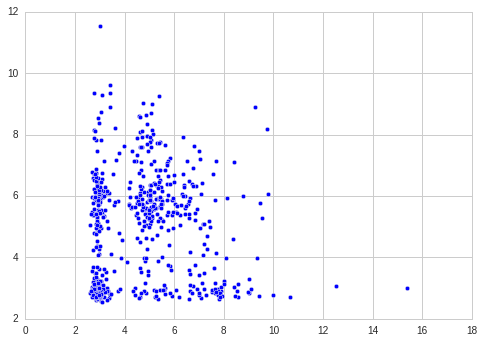

In [131]:
plt.scatter(all_features_conc["Lig900-O1 to His297"].iloc[::400], all_features_conc["ALA240 to TRP293"].iloc[::400])

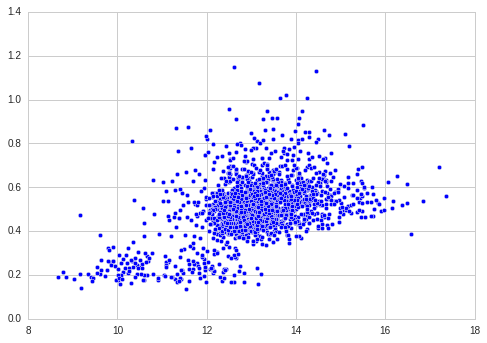

In [165]:
plt.scatter(features_eq["ASN328_CA to ILE155_CA"].iloc[::10], features_eq["rmsd_npxxy_active"].iloc[::10])
#plt.scatter(features_eq["PHE289 to PRO244"].iloc[::10], features_eq["ILE256_CA to LEU275_CA"].iloc[::10])

(array([  1.80000000e+01,   5.44000000e+02,   3.37800000e+03,
          9.70600000e+03,   1.59750000e+04,   1.83800000e+04,
          1.68050000e+04,   1.32290000e+04,   1.06780000e+04,
          9.85100000e+03,   1.02520000e+04,   1.14930000e+04,
          1.28760000e+04,   1.26720000e+04,   1.13220000e+04,
          9.35200000e+03,   7.82200000e+03,   6.54800000e+03,
          5.67000000e+03,   5.30400000e+03,   5.40800000e+03,
          5.67300000e+03,   5.92700000e+03,   6.01700000e+03,
          5.87600000e+03,   5.28800000e+03,   4.64700000e+03,
          3.89800000e+03,   3.25100000e+03,   2.60500000e+03,
          2.12100000e+03,   1.65100000e+03,   1.21000000e+03,
          8.64000000e+02,   6.12000000e+02,   4.43000000e+02,
          3.09000000e+02,   2.28000000e+02,   1.59000000e+02,
          1.03000000e+02,   8.40000000e+01,   7.60000000e+01,
          5.80000000e+01,   4.00000000e+01,   2.50000000e+01,
          2.00000000e+01,   1.60000000e+01,   1.00000000e+01,
        

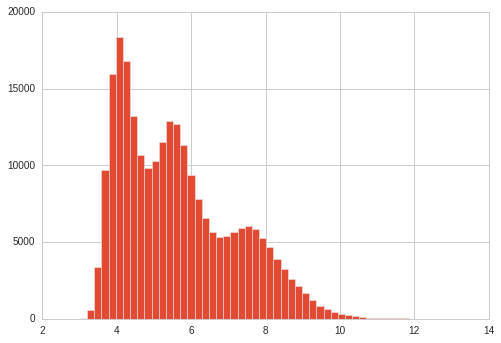

In [128]:
plt.hist(all_features_conc["Lig900-C10 to Met151"], bins=50)

In [75]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time'

In [ ]:
coords_bounds_dict = {"tm6_tm3_packing": [8.0, 10., 12.0, 16.0]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5",user_defined_coords, 
                            sorted(feature_name_residues_dict.keys()), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)
print([t for t in trajs_to_watch.values()[0] if "bu72" in t])

In [174]:
with open("/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/analysis_n_clusters1000_random-1000clusters_25lag-time/suf_features_eq.pkl", "rb") as f:
    suf_features_eq = pickle.load(f)

clusterer100 = verboseload("%s/clusterer_100clusters.h5" %pp_tica_dir)
model_name = 'agonist_rfr_trials1000_split0.9_normalizeFalse_normalize-axis0True_n-estimators1000_precisionXP'
with open("/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/analysis_n_clusters100_random/%s.pkl" %model_name, "rb") as f:
    rf_model = pickle.load(f)

clusterer100.cluster_centers_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5"...


array([[  4.76137585e-02,   1.61640629e+00,   4.84334932e-02,
         -3.31092012e-01,  -6.02227389e-01,  -6.23136790e-01,
         -2.70002407e-01,  -2.11510738e+00,  -3.42387688e-01,
         -3.69607187e-01],
       [ -4.05014841e-01,  -5.76457960e-01,  -4.42959988e-01,
         -7.28525717e-03,  -2.04153079e-01,  -2.02465474e-01,
          1.05449104e-01,   1.11168395e-01,   2.36695408e-01,
         -3.68616052e-01],
       [  5.57448208e+00,  -4.61840078e-01,  -1.53572866e+00,
          2.94312319e-02,   1.57948181e-01,  -1.70709720e-01,
          5.39254552e-01,   2.42341360e-01,  -3.53098225e-01,
          1.05430831e-01],
       [ -2.15442101e-01,  -7.53440531e-01,  -3.13388010e-01,
          3.18415185e-04,  -9.22728264e-02,   8.31324355e-01,
          2.05292211e+00,   1.61051876e-01,  -3.71366836e-01,
          4.14899855e-01],
       [  8.01198907e-03,   2.12618325e+00,   2.39164424e-01,
          1.65649736e+00,  -3.37689058e-01,  -8.93440116e-01,
         -3.76079219e-02

In [163]:

suf_features_eq = suf_features_eq[[c for c in suf_features_eq.columns.values.tolist() if "Lig" not in c]]
bu72_features_eq = features_eq[[c for c in features_eq.columns.values.tolist() if "Lig" not in c]]
features_eq_conc = pd.concat([apo_features_eq, suf_features_eq, bu72_features_eq], axis=0)
custom_lims = custom_lim_finder([features_eq_conc[["mOR tIC.1", "mOR tIC.2"]].values])



(array([  6.,  17.,  15.,  21.,  22.,  14.,  16.,   8.,  10.,  11.,   8.,
          9.,   3.,   3.,   6.,   4.,   3.,   4.,   3.,   3.,   2.,   0.,
          0.,   1.,   3.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.00111589,  0.00149629,  0.00187669,  0.00225709,  0.00263749,
         0.00301789,  0.00339829,  0.00377869,  0.00415909,  0.00453949,
         0.0049199 ,  0.0053003 ,  0.0056807 ,  0.0060611 ,  0.0064415 ,
         0.0068219 ,  0.0072023 ,  0.0075827 ,  0.0079631 ,  0.0083435 ,
         0.0087239 ,  0.00

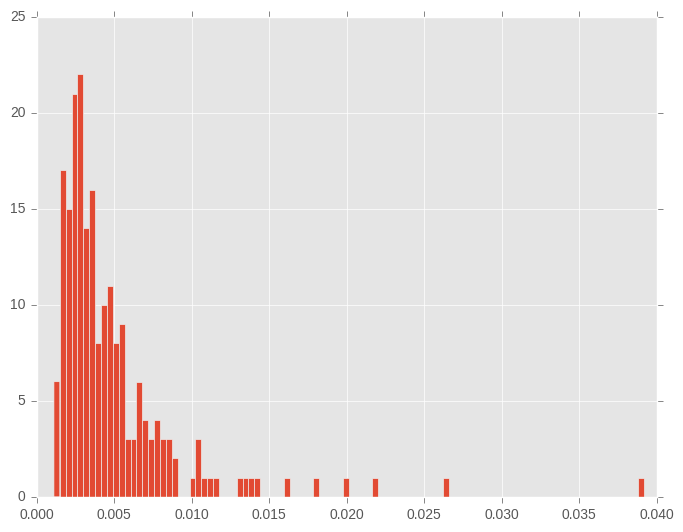

In [186]:
plt.hist(rf_model["MSM Docking"][1],bins=100)

In [177]:
with open('/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/analysis_n_clusters100_random/agonist_rfr_trials1000_split0.9_normalizeFalse_normalize-axis0True_n-estimators1000_precisionXP_new_df.pkl', "rb") as f:
    docking_df = pickle.load(f)
new_cols = [n for n in docking_df.columns.values if "state" in n.lower()]
print(rf_model["MSM Docking"][1].shape)
importance_df = pd.DataFrame(rf_model["MSM Docking"][1].reshape((-1,1)), index=docking_df.columns, columns=["feature_importance"])
importance_df = importance_df.loc[new_cols]
coords_df = pd.DataFrame(clusterer100.cluster_centers_, index=["State %d" %i for i in range(0, 100)], columns=["mOR tIC.%d" %j for j in range(1,11)])
coords_df = coords_df.loc[importance_df.index]

(205,)


In [184]:
df = pd.concat([coords_df, importance_df], axis=1).sort("feature_importance", ascending=False, inplace=False)
df["feature_importance"]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


State 54    0.039156
State 54    0.039156
State 27    0.026242
State 27    0.026242
State 79    0.021679
State 79    0.021679
State 79    0.020052
State 79    0.020052
State 19    0.017925
State 19    0.017925
State 18    0.016209
State 18    0.016209
State 54    0.014114
State 54    0.014114
State 6     0.013707
State 6     0.013707
State 15    0.013348
State 15    0.013348
State 32    0.013253
State 32    0.013253
State 6     0.011633
State 6     0.011633
State 80    0.010550
State 80    0.010550
State 25    0.010365
State 25    0.010365
State 71    0.010298
State 71    0.010298
State 35    0.010244
State 35    0.010244
State 81    0.009012
State 81    0.009012
State 80    0.008731
State 80    0.008731
State 92    0.008394
State 92    0.008394
State 1     0.008379
State 1     0.008379
State 26    0.008346
State 26    0.008346
State 27    0.008329
State 27    0.008329
State 4     0.008218
State 4     0.008218
State 90    0.007848
State 90    0.007848
State 32    0.007785
State 32    0

In [144]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time'

In [153]:
cols = ["mOR tIC.1", "mOR tIC.4"]
custom_lims = custom_lim_finder(features_eq_conc[cols].values, n_stds=1.5)

In [154]:
custom_lims

[[-4.0084033170789706, 9.77440619411251],
 [-7.0477848687498019, 8.4013066447003695]]

hi
(2, 59976)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)


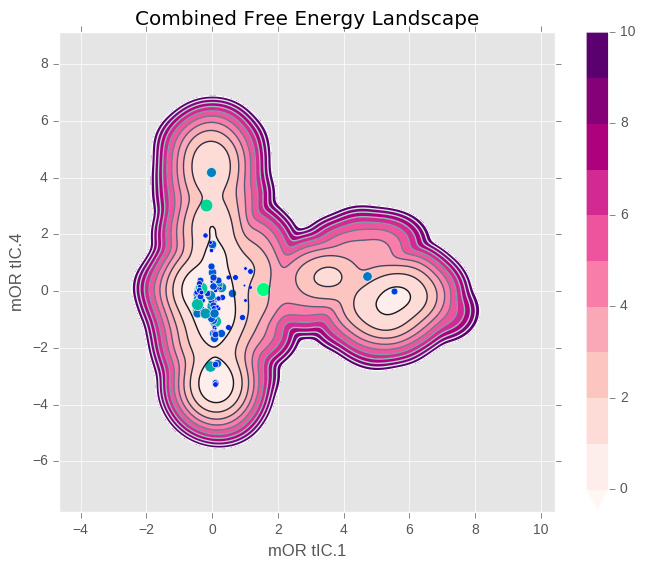

In [155]:
jointplot((0,1), features_eq_conc[cols].values, save_dir=analysis_dir, titles=cols,
              main="Combined Free Energy Landscape", custom_lims=custom_lims,
              max_tIC=5, min_density=None, max_diff=10., n_levels=11, n_pts=200j,
              remake=True, superpose_circles={"radii": importance_df.values, "coords": coords_df[cols].values},
              cmap=plt.cm.get_cmap("RdPu"))

hi
(2, 19998)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)
[[ 0.1997732  -1.66948062]
 [-0.27086734  0.09047833]]


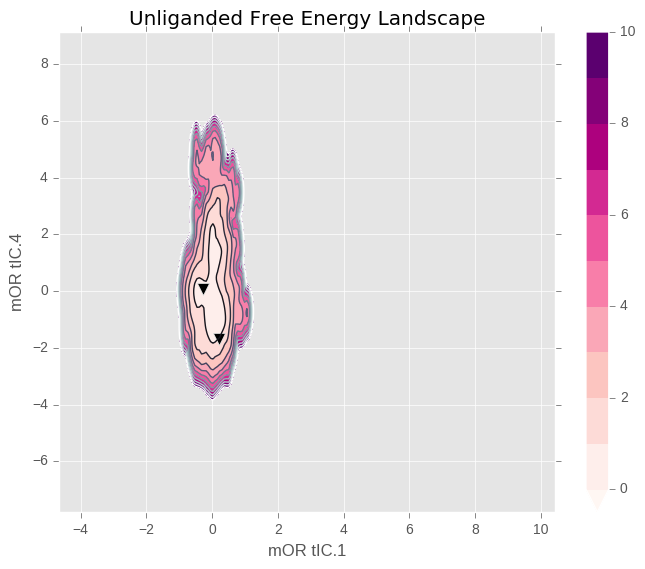

In [159]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

jointplot((0,1), apo_features_eq[cols].values, save_dir=analysis_dir, titles=cols,
              main="Unliganded Free Energy Landscape", custom_lims=custom_lims,
              max_tIC=5, min_density=None, max_diff=10., n_levels=11, n_pts=200j,
              remake=True, refcoords=ref_features[cols].values,
              cmap=plt.cm.get_cmap("RdPu"))

hi
(2, 19984)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)
[[ 0.1997732  -1.66948062]
 [-0.27086734  0.09047833]]


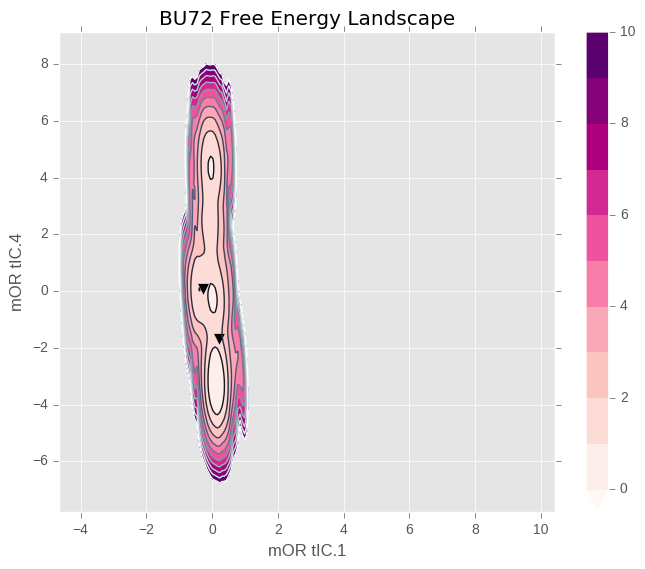

In [160]:
jointplot((0,1), bu72_features_eq[cols].values, save_dir=analysis_dir, titles=cols,
              main="BU72 Free Energy Landscape", custom_lims=custom_lims,
              max_tIC=5, min_density=None, max_diff=10., n_levels=11, n_pts=200j,
              remake=True, refcoords=ref_features[cols].values,
              cmap=plt.cm.get_cmap("RdPu"))

hi
(2, 19994)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)
[[ 0.1997732  -1.66948062]
 [-0.27086734  0.09047833]]


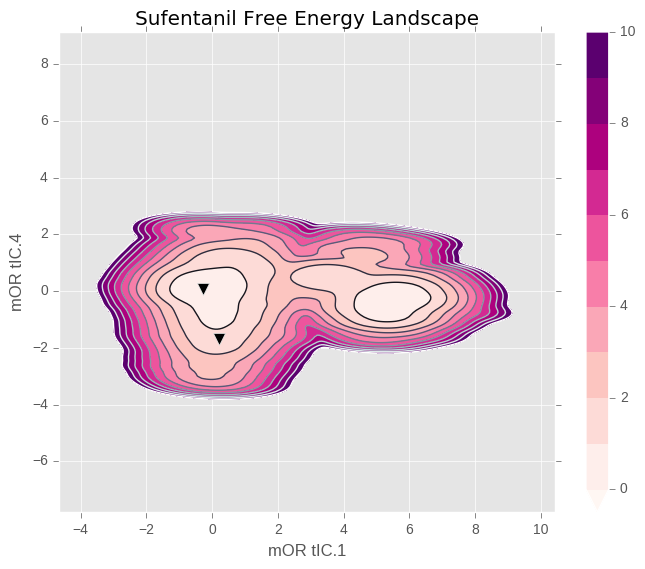

In [161]:
jointplot((0,1), suf_features_eq[cols].values, save_dir=analysis_dir, titles=cols,
              main="Sufentanil Free Energy Landscape", custom_lims=custom_lims,
              max_tIC=5, min_density=None, max_diff=10., n_levels=11, n_pts=200j,
              remake=True, refcoords=ref_features[cols].values,
              cmap=plt.cm.get_cmap("RdPu"))

In [135]:
custom_lim_finder(features_eq_conc[cols].values)

[[-3.0898291975041445, 8.855832074537684],
 [-2.9393033637905353, 4.7218198810198082]]

In [ ]:
jointplot((0,1), features_eq[["mOR tIC.1", "mOR tIC.4"]].values, save_dir=analysis_dir, titles=["tIC.1", "tIC.4"],
              main="BU72 Free Energy Landscape", custom_lims=None,
              max_tIC=5, min_density=None, max_diff=10., n_levels=11, n_pts=200j,
              remake=True, refcoords=ref_features[["mOR tIC.1", "mOR tIC.4"]]
              cmap=plt.cm.get_cmap("RdPu"))

In [115]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time'

In [96]:
features_eq_conc[["mOR tIC.1", "mOR tIC.2"]].shape

(59976, 2)

In [98]:
custom_lims.shape

AttributeError: 'list' object has no attribute 'shape'

In [117]:
np.argsort(rf_model["MSM Docking"][1])

array([ 94,  63,  40,  18,  96,  61,  69,  42,  24, 100,  86,  17,  60,
        59,  56,  26,  33,  82,  57,  47,  87,  48,  64,  23,  74,  25,
         7,  97,  53,  35,  22,   2,  67,  95,  89,  85,  84,  31,   4,
        30,  37, 101,  62,  10,  71,  49,  76,  88,   5,  90,   3,  99,
        39,   9,  65,  79,  58,  55,  73,  70,  83,  93,  92,  28,  44,
        38,  43,  54,   1,  52,  16,  72,  91,  14, 102,  50,  45,  29,
        81,  77,  41,   0,  46,  15,  13,  66,  98,  34,  20,  32,  12,
        21,  27,  19,  75,  11,  51,  80,   6,   8,  68,  36,  78])